In [408]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
import statsmodels.api as sm
import os

In [409]:
nombre_carpeta = "img"

if not os.path.exists(nombre_carpeta):
    os.mkdir(nombre_carpeta)
    print(f"Carpeta '{nombre_carpeta}' creada exitosamente.")
else:
    print(f"La carpeta '{nombre_carpeta}' ya existe.")
#Hasta aquí es para crear carpeta con nombre img

# ax = sns.countplot(df_features['genre'])
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90,size=13)
# ax.set_title('Distribution Of Genres Across TheData',fontsize=16)
# ax.patches[12].set_fc('r')
# plt.style.use('ggplot')
# plt.savefig('img/grafico.png')

La carpeta 'img' ya existe.


In [410]:
from utils.funciones import *

In [411]:
import warnings
warnings.filterwarnings('ignore')

## Consideraciones generales

¡Ojo! Los animes están separados por temporadas. ¿Conviene que haya solo una fila por anime, sumando datos cuando sea necesario (como x ejemplo núm de personas que la puntuaron) y haciendo media de datos cuando sea necesario (la puntuación, x ejemplo)?

### Data Cleaning
- Se elimina la columna "ID", "Synonyms", "Japanese", "Synopsis" , "End_Aired", "Producers", Licensors", "Popularity", "Members", "Favourite", "Premiered" y "Broadcast" por no aportar datos relevantes o por exceso de "Unknowns"
- Se plantea eliminar la columna "Title" y renombrar la columna "English" por "Title". Sin embargo, aunque eso lo haría más comprensible para el público general, se comprueba que la columna "English" tiene más de 11K "Unknown". Se decide dejar ambas columnas
- Se eliminan las filas donde "Title" == "Unknown" porque no aporta valor la fila de un anime sin título
- Se eliminan las filas donde "Start_Aired" == "Unknown" porque no aporta valor el desconocimiento de la fecha en la que se estrena.
- Se eliminan las filas donde "Demographics" == "Unknown" porque para el posterior análisis estadístico es imprescindible que no haya Unknowns.
- Tras limpiar todo el dataframe, se decide que hay que quitar todos los Unknown. A la hora de las gráficas destacan demasiado.
- En las columnas "Demographics", "Themes" y "Genres" se reemplazan los valores que tienen más de una palabra y se añaden a la categoría de la primera palabra. Por ejemplo, en "Demographics", "Kids, Shounen" se reemplaza por "Kids". Al ser una categoría ya existente, se suman los valores


### Missing values
    1. Tras hacer dos pruebas donde, por un lado, se reemplazan los NaN por la media de los valores en las columnas "Score" y "Scored_User"   y,  por otro lado, se eliminan las filas de esas columnas cuando hay un NaN, se decide mantener las filas y rellenarlas con el valor medio de esas columnas
    2. Se decide hacer lo mismo con las columnas "Episodes" y "Duration_Minutes", tras comprobar que los NaN aparecen tanto en series, como en pelis.
    3. En "Ranked" no tiene sentido rellenar los NaN con la media, porque es un ranking del 1 al **. Tras verificar la columna Ranked, se decide eliminar las filas donde "Ranked" == NaN. Se comprueba además que eliminando los Unknown de "Ranked" desaparecen los "Status" == "Not yet aired", dejando datos que tienen más valor para nuestras hipótesis

## Posibles Hipótesis

- Los 10 animes con mejor ranking son Shounen (demográfica)
- La puntuación está relacionada de forma inversa con la duración (a mayor duración, menor puntuación)
- Los animes cuya emisión empezó antes de los 2010 tienen peor puntuación que los animes que empezaron a emitirse después del 01/01/2010
- Los animes de género comedia tienen más posibilidades de tener una puntuación superior a 4/5
- La puntuación de las películas es inferior a las de las series
- Los animes de aventura tienen más usuarios que puntúan en comparación a comedia, pero la puntuación media es menor
-~~Los animes que se emiten en fin de semana (viernes, sábado, domingo) tienen mejor puntuación que los que se emiten entre semana~~ DESCARTADO. La columna Broadcast tiene demasiados Unknowns
- Los animes basados en manga tienen una puntuación media superior a los animes originales - histograma (pero se puede hacer con estadística)/ boxplot

In [412]:
anime = pd.read_csv('data/raw/Anime.csv', sep=",")
anime.head(3)

,ID,Title,Synonyms,Japanese,English,Synopsis,Type,Episodes,Status,Start_Aired,...,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users,Ranked,Popularity,Members,Favorites
0,16498,Shingeki no Kyojin,"AoT, SnK",進撃の巨人,Attack on Titan,"Centuries ago, mankind was slaughtered to near...",TV,25.0,Finished Airing,"Apr 7, 2013",...,"Gore, Military, Survival",Shounen,24.0,R - 17+ (violence & profanity),8.531,519803.0,1002.0,1,3524109,155695
1,1535,Death Note,DN,デスノート,Death Note,"Brutal murders, petty thefts, and senseless vi...",TV,37.0,Finished Airing,"Oct 4, 2006",...,Psychological,Shounen,23.0,R - 17+ (violence & profanity),8.621,485487.0,732.0,2,3504535,159701
2,5114,Fullmetal Alchemist: Brotherhood,"Hagane no Renkinjutsushi Fullmetal Alchemist, ...",鋼の錬金術師 FULLMETAL ALCHEMIST,Fullmetal Alchemist Brotherhood,After a horrific alchemy experiment goes wrong...,TV,64.0,Finished Airing,"Apr 5, 2009",...,Military,Shounen,24.0,R - 17+ (violence & profanity),9.131,900398.0,12.0,3,2978455,207772


In [413]:
anime.tail(3)

,ID,Title,Synonyms,Japanese,English,Synopsis,Type,Episodes,Status,Start_Aired,...,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users,Ranked,Popularity,Members,Favorites
21457,45059,Yongzhe Chuang Mo Cheng,Unknown,勇者闯魔城,Brave City,Unknown,Movie,1.0,Finished Airing,"Mar 16, 2018",...,Unknown,Unknown,80.0,G - All Ages,NaN,NaN,164032.0,21489,6,0
21458,45063,Yu Shen Chuan: Wangzhe Shaonian,Unknown,禹神传之王者少年,The Juvenile of King Yu,Unknown,Movie,1.0,Finished Airing,"Aug 15, 2018",...,Unknown,Unknown,90.0,G - All Ages,NaN,NaN,164462.0,21490,6,0
21459,45061,Konglong Wang,Unknown,恐龙王,Dino King,Unknown,Movie,1.0,Finished Airing,"Nov 10, 2018",...,Historical,Kids,95.0,G - All Ages,NaN,NaN,193202.0,21490,6,0


In [414]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21460 entries, 0 to 21459
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                21460 non-null  int64  
 1   Title             21460 non-null  object 
 2   Synonyms          21460 non-null  object 
 3   Japanese          21460 non-null  object 
 4   English           21460 non-null  object 
 5   Synopsis          21460 non-null  object 
 6   Type              21460 non-null  object 
 7   Episodes          20913 non-null  float64
 8   Status            21460 non-null  object 
 9   Start_Aired       21460 non-null  object 
 10  End_Aired         21460 non-null  object 
 11  Premiered         21460 non-null  object 
 12  Broadcast         21460 non-null  object 
 13  Producers         21460 non-null  object 
 14  Licensors         21460 non-null  object 
 15  Studios           21460 non-null  object 
 16  Source            21460 non-null  object

In [415]:
anime.describe()

,ID,Episodes,Duration_Minutes,Score,Scored_Users,Ranked,Popularity,Members,Favorites
count,21460.000000,20913.000000,20861.000000,14562.000000,14562.000000,19536.000000,21460.000000,2.146000e+04,21460.000000
mean,26458.575582,13.272892,23.934135,6.421724,26507.173809,97795.212019,10743.103681,3.926596e+04,462.214865
std,17100.477121,48.792326,24.676538,0.910469,84989.501599,56485.384273,6204.685188,1.566359e+05,4411.931536
min,1.000000,1.000000,1.000000,1.841000,101.000000,12.000000,1.000000,6.000000e+00,0.000000
25%,8454.750000,1.000000,5.000000,5.791000,418.000000,48879.500000,5369.750000,2.910000e+02,0.000000
50%,31004.500000,2.000000,22.000000,6.431000,1876.500000,97777.000000,10741.500000,1.582500e+03,2.000000
75%,40495.250000,12.000000,26.000000,7.081000,11406.500000,146714.500000,16119.250000,1.158550e+04,23.000000
max,53094.000000,3057.000000,168.000000,9.131000,997243.000000,195632.000000,21490.000000,3.524109e+06,207772.000000


In [416]:
anime.columns

Index(['ID', 'Title', 'Synonyms', 'Japanese', 'English', 'Synopsis', 'Type',
       'Episodes', 'Status', 'Start_Aired', 'End_Aired', 'Premiered',
       'Broadcast', 'Producers', 'Licensors', 'Studios', 'Source', 'Genres',
       'Themes', 'Demographics', 'Duration_Minutes', 'Rating', 'Score',
       'Scored_Users', 'Ranked', 'Popularity', 'Members', 'Favorites'],
      dtype='object')

In [417]:
anime.isnull().sum()


ID                     0
Title                  0
Synonyms               0
Japanese               0
English                0
Synopsis               0
Type                   0
Episodes             547
Status                 0
Start_Aired            0
End_Aired              0
Premiered              0
Broadcast              0
Producers              0
Licensors              0
Studios                0
Source                 0
Genres                 0
Themes                 0
Demographics           0
Duration_Minutes     599
Rating                 0
Score               6898
Scored_Users        6898
Ranked              1924
Popularity             0
Members                0
Favorites              0
dtype: int64

In [418]:
anime[["Status"]].value_counts()

Status          
Finished Airing     20693
Not yet aired         442
Currently Airing      325
dtype: int64

In [419]:
# Missing values
# Escenario 1: Eliminar todas las filas que no tengan score. De poco nos sirven para hacer hipótesis luego, pero representan el 32% de las filas

anime_delete_nan = anime.dropna(subset=["Score", "Scored_Users"], axis=0)

#Escenario 2: Fill value con la media de Score y Score_users

anime_fill_mean = anime.fillna({"Score": anime["Score"].mean(), "Scored_Users": anime["Scored_Users"].mean()})

In [420]:
anime.describe()

,ID,Episodes,Duration_Minutes,Score,Scored_Users,Ranked,Popularity,Members,Favorites
count,21460.000000,20913.000000,20861.000000,14562.000000,14562.000000,19536.000000,21460.000000,2.146000e+04,21460.000000
mean,26458.575582,13.272892,23.934135,6.421724,26507.173809,97795.212019,10743.103681,3.926596e+04,462.214865
std,17100.477121,48.792326,24.676538,0.910469,84989.501599,56485.384273,6204.685188,1.566359e+05,4411.931536
min,1.000000,1.000000,1.000000,1.841000,101.000000,12.000000,1.000000,6.000000e+00,0.000000
25%,8454.750000,1.000000,5.000000,5.791000,418.000000,48879.500000,5369.750000,2.910000e+02,0.000000
50%,31004.500000,2.000000,22.000000,6.431000,1876.500000,97777.000000,10741.500000,1.582500e+03,2.000000
75%,40495.250000,12.000000,26.000000,7.081000,11406.500000,146714.500000,16119.250000,1.158550e+04,23.000000
max,53094.000000,3057.000000,168.000000,9.131000,997243.000000,195632.000000,21490.000000,3.524109e+06,207772.000000


In [421]:
anime_fill_mean.describe()

,ID,Episodes,Duration_Minutes,Score,Scored_Users,Ranked,Popularity,Members,Favorites
count,21460.000000,20913.000000,20861.000000,21460.000000,21460.000000,19536.000000,21460.000000,2.146000e+04,21460.000000
mean,26458.575582,13.272892,23.934135,6.421724,26507.173809,97795.212019,10743.103681,3.926596e+04,462.214865
std,17100.477121,48.792326,24.676538,0.749991,70009.365799,56485.384273,6204.685188,1.566359e+05,4411.931536
min,1.000000,1.000000,1.000000,1.841000,101.000000,12.000000,1.000000,6.000000e+00,0.000000
25%,8454.750000,1.000000,5.000000,6.121000,836.000000,48879.500000,5369.750000,2.910000e+02,0.000000
50%,31004.500000,2.000000,22.000000,6.421724,10078.000000,97777.000000,10741.500000,1.582500e+03,2.000000
75%,40495.250000,12.000000,26.000000,6.741000,26507.173809,146714.500000,16119.250000,1.158550e+04,23.000000
max,53094.000000,3057.000000,168.000000,9.131000,997243.000000,195632.000000,21490.000000,3.524109e+06,207772.000000


In [422]:
anime_delete_nan.describe()

,ID,Episodes,Duration_Minutes,Score,Scored_Users,Ranked,Popularity,Members,Favorites
count,14562.000000,14484.000000,14548.000000,14562.000000,14562.000000,13101.000000,14562.000000,1.456200e+04,14562.000000
mean,20594.421165,11.557028,25.902461,6.421724,26507.173809,65562.428212,7621.341505,5.722612e+04,676.756558
std,16126.674776,49.790280,25.062154,0.910469,84989.501599,37859.741238,4555.862784,1.873302e+05,5340.983416
min,1.000000,1.000000,1.000000,1.841000,101.000000,12.000000,1.000000,1.720000e+02,0.000000
25%,4494.250000,1.000000,7.000000,5.791000,418.000000,32782.000000,3713.000000,1.256000e+03,1.000000
50%,18062.000000,2.000000,23.000000,6.431000,1876.500000,65552.000000,7489.500000,5.137500e+03,8.000000
75%,35734.750000,12.000000,27.000000,7.081000,11406.500000,98322.000000,11319.000000,2.777175e+04,61.000000
max,53075.000000,3057.000000,168.000000,9.131000,997243.000000,131202.000000,18014.000000,3.524109e+06,207772.000000


In [423]:
#Se decide fill value con la media de Score y Score_users
anime.fillna({"Score": anime["Score"].mean(), "Scored_Users": anime["Scored_Users"].mean()}, inplace=True)

In [424]:
#Verificamos que los episodios que tienen un NaN son de diferentes tipos ( hay animes, pelis, etc), por lo que se pueden
#rellenar con la media
anime.loc[anime["Episodes"].isnull()]. head(2)

,ID,Title,Synonyms,Japanese,English,Synopsis,Type,Episodes,Status,Start_Aired,...,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users,Ranked,Popularity,Members,Favorites
24,21,One Piece,OP,ONE PIECE,One Piece,"Gol D. Roger was known as the ""Pirate King,"" t...",TV,NaN,Currently Airing,"Oct 20, 1999",...,Unknown,Shounen,24.0,PG-13 - Teens 13 or older,8.671,121979.0,582.0,25,1967217,177620
194,34566,Boruto: Naruto Next Generations,Unknown,BORUTO -NARUTO NEXT GENERATIONS-,Boruto Naruto Next Generations,Following the successful end of the Fourth Shi...,TV,NaN,Currently Airing,"Apr 5, 2017",...,Martial Arts,Shounen,23.0,PG-13 - Teens 13 or older,5.781,386342.0,100332.0,195,773091,6687


In [425]:
#Verificamos que la duración que tiene un NaN son de diferentes tipos, por lo que se pueden rellenar con la media
anime.loc[anime["Duration_Minutes"].isnull()].head(2)

,ID,Title,Synonyms,Japanese,English,Synopsis,Type,Episodes,Status,Start_Aired,...,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users,Ranked,Popularity,Members,Favorites
362,44511,Chainsaw Man,Unknown,チェンソーマン,Chainsaw Man,Denji has a simple dream—to live a happy and p...,TV,NaN,Not yet aired,"Oct 12, 2022",...,Gore,Shounen,NaN,None,6.421724,26507.173809,NaN,364,509913,14181
813,50172,Mob Psycho 100 III,"Mob Psycho 100 3rd Season, Mob Psycho Hyaku, M...",モブサイコ100 III,Mob Psycho 100 III,Third season of Mob Psycho 100.,TV,NaN,Not yet aired,"Oct 6, 2022",...,Super Power,Unknown,NaN,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,814,250031,2785


In [426]:
#Quiero comprobar si rellenar los NaN de "Episode" con la media es realista, o va a afectar a muchas películas.
#en Type, cuántos tipos hay y cuáles son Unknown?
anime["Type"].value_counts()
anime[anime["Type"] == "Unknown"]
# Descomentando el código anterior, vemos que solo hay 45 unknowns. Buscando unos cuantos en google vemos que hay series en su mayoría.
#Resumiendo: Es buena idea rellenar los Nan de "Episode" con la media de la columna

,ID,Title,Synonyms,Japanese,English,Synopsis,Type,Episodes,Status,Start_Aired,...,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users,Ranked,Popularity,Members,Favorites
2693,52299,Ore dake Level Up na Ken,"Na Honjaman Level Up, I Level Up Alone, 나 혼자만 레벨업",俺だけレベルアップな件,Solo Leveling,"Ten years ago, ""the Gate"" appeared and connect...",Unknown,NaN,Not yet aired,2023,...,Unknown,Unknown,NaN,None,6.421724,26507.173809,NaN,2695,51020,1082
2954,53065,Sono Bisque Doll wa Koi wo Suru (Zoku-hen),KiseKoi,その着せ替え人形は恋をする (続編),My Dress-Up Darling (Sequel),Sequel of Sono Bisque Doll wa Koi wo Suru.,Unknown,NaN,Not yet aired,Unknown,...,"Otaku Culture, School",Seinen,NaN,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,2956,44290,177
3063,51533,Tonikaku Kawaii: Seifuku,Unknown,トニカクカワイイ ~制服~,Tonikawa Over the Moon for You - Uniform,Special episode of Tonikaku Kawaii scheduled t...,Unknown,1.0,Not yet aired,"Nov 22, 2022",...,Unknown,Shounen,NaN,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,3065,40070,172
3531,49469,Beastars (Shin Shou),Beastars Final Season,BEASTARS (新章),Unknown,New Beastars sequel.,Unknown,NaN,Not yet aired,Unknown,...,"Psychological, School",Shounen,NaN,R - 17+ (violence & profanity),6.421724,26507.173809,NaN,3532,30539,61
3533,44304,Code Geass: Dakkan no Z,Code Geass Z of the Recapture,コードギアス 奪還のゼット,Unknown,Unknown,Unknown,NaN,Not yet aired,Unknown,...,"Mecha, Military, Super Power",Unknown,NaN,None,6.421724,26507.173809,NaN,3534,30517,83
3723,50803,Jaku-Chara Tomozaki-kun (Shinsaku Anime),Bottom-Tier Character Tomozaki,弱キャラ友崎くん (新作アニメ),Unknown,New anime project for Jaku Chara Tomozaki-kun.,Unknown,NaN,Not yet aired,Unknown,...,School,Unknown,NaN,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,3726,27534,160
4137,50713,Mahouka Koukou no Rettousei (Zoku-hen),Unknown,魔法科高校の劣等生 (続編),The Irregular at Magic High School Reminiscenc...,Unknown,Unknown,NaN,Not yet aired,Unknown,...,Unknown,Unknown,NaN,R - 17+ (violence & profanity),6.421724,26507.173809,NaN,4141,21901,55
4395,40054,Akira (Shin Anime),Unknown,アキラ (新アニメ),Unknown,A new anime adaptation for Otomo's highly accl...,Unknown,NaN,Not yet aired,Unknown,...,Military,Seinen,NaN,None,6.421724,26507.173809,NaN,4400,19122,26
4425,52293,New Panty & Stocking with Garterbelt,Panty & Stocking with Garterbelt 2nd Season,New Panty&Stocking with Garterbelt,Unknown,Unknown,Unknown,NaN,Not yet aired,Unknown,...,Unknown,Unknown,NaN,None,6.421724,26507.173809,NaN,4429,18793,78
4619,52093,Trigun Stampede,Unknown,TRIGUN STAMPEDE,Trigun Stampede,New anime project for Trigun.,Unknown,NaN,Not yet aired,2023,...,Adult Cast,Shounen,NaN,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,4624,17063,71


In [427]:
anime.fillna({"Episodes": anime["Episodes"].mean(), "Duration_Minutes": anime["Duration_Minutes"].mean()}, inplace=True)

In [428]:
#Verificamos la columna "Ranked". Justo los que no están en el ranking, tienen muchísimos Unknowns en otras columnas. Mejor eliminarlos.
ranked_nan = anime[anime['Ranked'].apply(lambda x: np.isnan(x))]
ranked_nan

,ID,Title,Synonyms,Japanese,English,Synopsis,Type,Episodes,Status,Start_Aired,...,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users,Ranked,Popularity,Members,Favorites
362,44511,Chainsaw Man,Unknown,チェンソーマン,Chainsaw Man,Denji has a simple dream—to live a happy and p...,TV,13.272892,Not yet aired,"Oct 12, 2022",...,Gore,Shounen,23.934135,None,6.421724,26507.173809,NaN,364,509913,14181
813,50172,Mob Psycho 100 III,"Mob Psycho 100 3rd Season, Mob Psycho Hyaku, M...",モブサイコ100 III,Mob Psycho 100 III,Third season of Mob Psycho 100.,TV,13.272892,Not yet aired,"Oct 6, 2022",...,Super Power,Unknown,23.934135,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,814,250031,2785
833,40357,Tate no Yuusha no Nariagari Season 3,"Tate no Yuusha no Nariagari 3rd Season, The Ri...",盾の勇者の成り上がり,The Rising of the Shield Hero Season 3,Third season of Tate no Yuusha no Nariagari.,TV,13.272892,Not yet aired,Unknown,...,Isekai,Unknown,23.934135,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,834,244491,2855
890,50602,Spy x Family Part 2,Unknown,SPY×FAMILY,Unknown,The second part of Spy x Family.,TV,13.000000,Not yet aired,"Oct 1, 2022",...,Childcare,Shounen,23.934135,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,891,229447,1628
915,49918,Boku no Hero Academia 6th Season,My Hero Academia 6,僕のヒーローアカデミア 6th Season,My Hero Academia Season 6,Sixth season of Boku no Hero Academia.,TV,13.272892,Not yet aired,"Oct 1, 2022",...,"School, Super Power",Shounen,23.934135,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,916,223328,1877
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21006,53047,Rou e Tian,Unknown,肉蛾天,Meat Days,"In a chaotic time of men eating men, A-e gets ...",Movie,1.000000,Finished Airing,2006,...,Gore,Unknown,12.000000,R+ - Mild Nudity,6.421724,26507.173809,NaN,21037,29,0
21017,51392,Shi Shi Chuanshuo,Unknown,师士传说,Unknown,Unknown,ONA,13.272892,Not yet aired,2022,...,Mecha,Unknown,23.934135,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,21048,29,0
21056,51287,Emo Faze,Unknown,恶魔法则,Law of Devil,Unknown,ONA,13.272892,Not yet aired,2022,...,Unknown,Unknown,23.934135,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,21085,29,0
21151,51390,Ying Yu Siwan Nian,Unknown,星域四万年,Unknown,Unknown,ONA,13.272892,Not yet aired,2022,...,Unknown,Unknown,23.934135,PG-13 - Teens 13 or older,6.421724,26507.173809,NaN,21181,27,0


In [429]:
#Eliminamos los Nan de "Ranked"
anime.dropna(subset=["Ranked"], axis=0, inplace=True)
anime.isnull().sum()

ID                  0
Title               0
Synonyms            0
Japanese            0
English             0
Synopsis            0
Type                0
Episodes            0
Status              0
Start_Aired         0
End_Aired           0
Premiered           0
Broadcast           0
Producers           0
Licensors           0
Studios             0
Source              0
Genres              0
Themes              0
Demographics        0
Duration_Minutes    0
Rating              0
Score               0
Scored_Users        0
Ranked              0
Popularity          0
Members             0
Favorites           0
dtype: int64

In [430]:
anime[["Demographics"]].value_counts()
#Hay un montón de Unknowns!!!

Demographics 
Unknown          11617
Kids              4219
Shounen           1972
Seinen             874
Shoujo             662
Josei               92
Kids, Shounen       66
Kids, Shoujo        32
Josei, Shoujo        1
Kids, Seinen         1
dtype: int64

In [431]:
#Eliminamos Unknowns
anime = anime.drop(index=anime.loc[anime['Demographics'] == 'Unknown'].index)

In [432]:
#Vamos a intentar dejar solo Kids, Shounen, Seinen, Shoujo y Josei. Las que tienen varias parabras, las unimos a la primera 

anime["Demographics"] = anime["Demographics"].str.replace('^Kids.*', 'Kids').str.replace('^Josei.*', 'Josei')
anime["Demographics"].value_counts()

Kids       4318
Shounen    1972
Seinen      874
Shoujo      662
Josei        93
Name: Demographics, dtype: int64

In [433]:
anime[["Themes"]].value_counts()

Themes                                
Unknown                                   3701
Music                                      603
School                                     314
Historical                                 254
Anthropomorphic                            210
                                          ... 
Adult Cast, Psychological, Team Sports       1
Historical, Military, Mythology              1
Historical, Mythology, School                1
Historical, Mythology, Space                 1
Historical, Racing                           1
Length: 442, dtype: int64

In [434]:
#Eliminamos Unknowns
anime = anime.drop(index=anime.loc[anime['Themes'] == 'Unknown'].index)

In [435]:
#Vamos a intentar dejar solo Temas con 1 palabra. Las que tienen varias parabras, las unimos a la primera. No sé hacerlo todo junto, así que he tenido que hacerlo uno por uno. 
#Explicacion del código: con .str.replace pedimos que reemplace una palabra por otra.
#^ indica el inicio de la línea o cadena de texto. Por lo tanto, ^Martial Arts significa "todas las líneas o cadenas de texto que comienzan con 'Martial Arts'".
# . significa cualquier caracter excepto el salto de línea. Por lo tanto, ^Martial Arts.* significa "todas las líneas o cadenas de texto que comienzan con 'Martial Arts'
# seguido de cualquier cosa".
# * significa cero o más repeticiones del elemento anterior. Por lo tanto, ^Martial Arts.* significa "todas las líneas o cadenas de texto que comienzan con 'Martial Arts'
# seguido de cualquier cosa, incluyendo la ausencia de cualquier cosa". 

anime['Themes'] = anime['Themes'].str.replace('^Martial Arts.*', 'Martial Arts').str.replace('^Historical.*', 'Historical').str.replace('^Harem.*', 'Harem').str.replace('^Mecha.*',
                     'Mecha').str.replace('^Crossdressing.*','Crossdressing').str.replace('^Educational.*', 'Educational').str.replace('^Adult Cast.*', 'Adult Cast').str.replace('^Gag Humor.*',
                     'Gag Humor').str.replace('^Gore.*', 'Gore').str.replace('^CGDCT.*', 'CGDCT').str.replace('^Detective.*', 'Detective').str.replace('^Mythology.*', 
                    'Mythology').str.replace('^Anthropomorphic.*', 'Anthropomorphic').str.replace('^Magical Sex Shift.*', 'Magical Sex Shift').str.replace('^Iyashikei.*', 'Iyashikei').str.replace('^Idols.*',
                     'Idols').str.replace('^Space.*', 'Space').str.replace('^Music.*', 'Music').str.replace('^Mahou Shoujo.*', 'Mahou Shoujo').str.replace('^School.*', 'School').str.replace('^Combat Sports.*',
                     'Combat Sports').str.replace('^Isekai.*', 'Isekai').str.replace('^Reverse Harem.*', 'Reverse Harem').str.replace('^Childcare.*', 'Childcare').str.replace('^Strategy Game.*',
                    'Strategy Game').str.replace('^Psychological.*', 'Psychological').str.replace('^Racing.*', 'Racing').str.replace('^Love Polygon.*', 'Love Polygon').str.replace('^Delinquents.*',
                     'Delinquents').str.replace('^Parody.*', 'Parody').str.replace('^Military.*', 'Military').str.replace('^Organized Crime.*', 'Organized Crime').str.replace('^Otaku Culture.*',
                    'Otaku Culture').str.replace('^High Stakes Game.*', 'High Stakes Game').str.replace('^Survival.*', 'Survival').str.replace('^Pets.*', 'Pets').str.replace('^Reincarnation.*',
                     'Reincarnation').str.replace('^Samurai.*', 'Samurai').str.replace('^Performing Arts.*', 'Performing Arts').str.replace('^Showbiz.*', 'Showbiz').str.replace('^Super Power.*',
                     'Super Power').str.replace('^Romantic Subtext.*', 'Romantic Subtext').str.replace('^Medical.*', 'Medical')
anime["Themes"].value_counts()

Music                656
Historical           428
School               413
Mecha                302
Anthropomorphic      243
Educational          181
Adult Cast           152
Super Power          136
Mythology            125
Martial Arts         118
Mahou Shoujo         116
Detective             95
Harem                 94
Gag Humor             92
Team Sports           90
Racing                89
Strategy Game         86
Parody                69
Idols                 58
Combat Sports         58
Iyashikei             57
Gore                  50
Space                 45
CGDCT                 42
Psychological         41
Military              40
Delinquents           31
Isekai                30
Childcare             28
Vampire               28
Love Polygon          26
Pets                  22
Reverse Harem         20
Organized Crime       17
Crossdressing         17
Otaku Culture         14
Magical Sex Shift     14
Workplace             14
Romantic Subtext      12
High Stakes Game      12


In [436]:
anime[["Genres"]].value_counts()

Genres                                   
Unknown                                      916
Comedy                                       256
Fantasy                                      164
Sports                                       127
Action                                       109
                                            ... 
Adventure, Fantasy, Romance                    1
Adventure, Fantasy, Romance, Supernatural      1
Adventure, Fantasy, Slice of Life              1
Adventure, Horror, Romance, Supernatural       1
Adventure, Drama, Slice of Life                1
Length: 388, dtype: int64

In [437]:
#Eliminamos Unknowns
anime = anime.drop(index=anime.loc[anime['Genres'] == 'Unknown'].index)

In [438]:
def clean_genres(animecol):
    animecol = animecol.str.replace('^Adventure.*', 'Adventure').str.replace('^Action.*', 'Action').str.replace('^Comedy.*', 'Comedy').str.replace('^Fantasy.*',
                'Fantasy').str.replace('^Mystery.*', 'Mystery').str.replace('^Drama.*', 'Drama').str.replace('^Avant Garde.*', 'Avant Garde').str.replace('^Boys Love.*',
                'Boys Love').str.replace('^Girls Love.*', 'Girls Love').str.replace('^Sports.*', 'Sports').str.replace('^Horror.*', 'Horror').str.replace('^Romance.*',
                'Romance').str.replace('^Award Winning.*', 'Award Winning').str.replace('^Gourmet.*', 'Gourmet').str.replace('^Sci-Fi.*', 'Sci-Fi').str.replace('^Slice of Life.*',
                'Slice of Life').str.replace('^Supernatural.*', 'Supernatural')
    return animecol


In [439]:
# anime["Genres"] = anime["Genres"].apply(clean_genres)

In [440]:
#Eliminamos Unknowns
anime = anime.drop(index=anime.loc[anime['Genres'] == 'Unknown'].index)

In [441]:
anime["Genres"]= anime["Genres"].str.replace('^Adventure.*', 'Adventure').str.replace('^Action.*', 'Action').str.replace('^Comedy.*', 'Comedy').str.replace('^Fantasy.*',
                'Fantasy').str.replace('^Mystery.*', 'Mystery').str.replace('^Drama.*', 'Drama').str.replace('^Avant Garde.*', 'Avant Garde').str.replace('^Boys Love.*',
                'Boys Love').str.replace('^Girls Love.*', 'Girls Love').str.replace('^Sports.*', 'Sports').str.replace('^Horror.*', 'Horror').str.replace('^Romance.*',
                'Romance').str.replace('^Award Winning.*', 'Award Winning').str.replace('^Gourmet.*', 'Gourmet').str.replace('^Sci-Fi.*', 'Sci-Fi').str.replace('^Slice of Life.*',
                'Slice of Life').str.replace('^Supernatural.*', 'Supernatural')
anime["Genres"].value_counts()

Action           1065
Comedy            901
Adventure         399
Drama             287
Fantasy           218
Sports            128
Sci-Fi             83
Romance            70
Slice of Life      70
Mystery            26
Supernatural       19
Gourmet            12
Horror              8
Boys Love           5
Avant Garde         4
Suspense            3
Ecchi               2
Girls Love          2
Name: Genres, dtype: int64

In [442]:
#La columna start_aired es object. Necesito que sea int y que solo aparezca el año. 
anime["Start_Aired"].value_counts()

Unknown         37
2005            20
2014            12
2009            11
2010            11
                ..
Apr 9, 2008      1
Feb 2, 1999      1
Jul 31, 2019     1
Apr 13, 1996     1
Nov 10, 2018     1
Name: Start_Aired, Length: 2380, dtype: int64

In [443]:
#Idea: quitar Unknowns y los sustituimos por el outlier 1900
#Máscara para que me muestre los unknowns. Hay 37
mask=(anime["Start_Aired"] == 'Unknown')
anime["Start_Aired"].loc[mask]

13116    Unknown
13762    Unknown
14133    Unknown
15620    Unknown
16125    Unknown
16616    Unknown
16807    Unknown
16817    Unknown
16909    Unknown
17769    Unknown
18032    Unknown
18093    Unknown
18223    Unknown
18253    Unknown
18457    Unknown
18520    Unknown
18544    Unknown
18620    Unknown
18622    Unknown
18808    Unknown
18811    Unknown
18909    Unknown
18910    Unknown
19170    Unknown
20396    Unknown
20960    Unknown
20995    Unknown
21202    Unknown
21300    Unknown
21399    Unknown
21418    Unknown
21419    Unknown
21426    Unknown
21446    Unknown
21447    Unknown
21449    Unknown
21451    Unknown
Name: Start_Aired, dtype: object

In [444]:
#Ahora que me muestre si hay algún anime en 1900 de base. Serie vacía. No hay.
mask=(anime["Start_Aired"] == "1900")
anime["Start_Aired"].loc[mask]

Series([], Name: Start_Aired, dtype: object)

In [445]:
#Por cada elemento de la columna start_aired que sea Unknown, lo convierto en 1900 como número
for i in anime["Start_Aired"]:
    if i == 'Unknown':
        anime["Start_Aired"][anime["Start_Aired"] == 'Unknown'] = 1900

In [446]:
#Vuelvo a verificar si ahora hay 1900 ( en número). Hay 37, los mismos que antes eran Unk.
mask=(anime["Start_Aired"] == 1900)
anime["Start_Aired"].loc[mask]

13116    1900
13762    1900
14133    1900
15620    1900
16125    1900
16616    1900
16807    1900
16817    1900
16909    1900
17769    1900
18032    1900
18093    1900
18223    1900
18253    1900
18457    1900
18520    1900
18544    1900
18620    1900
18622    1900
18808    1900
18811    1900
18909    1900
18910    1900
19170    1900
20396    1900
20960    1900
20995    1900
21202    1900
21300    1900
21399    1900
21418    1900
21419    1900
21426    1900
21446    1900
21447    1900
21449    1900
21451    1900
Name: Start_Aired, dtype: object

In [447]:
anime["Start_Aired"].value_counts()

1900            37
2005            20
2014            12
2009            11
2010            11
                ..
Apr 9, 2008      1
Feb 2, 1999      1
Jul 31, 2019     1
Apr 13, 1996     1
Nov 10, 2018     1
Name: Start_Aired, Length: 2380, dtype: int64

In [448]:
#Vamos a convertir las fechas con formato "Apr 7, 2013 en 2013 (ejemplo). Buscamos una fila para hacer la prueba. 
anime["Start_Aired"].iloc[0]

'Apr 7, 2013'

In [449]:
#La primera fila nos vale. Vamos a hacer un split y que nos deje solo el año en formato int
int(anime["Start_Aired"].iloc[0].split()[-1])

2013

In [450]:
#Vamos a crear un bucle para que recorra toda la columna y convierta a int las fechas con formato "Apr 7, 2013", dejando solo el año. 
errores = pd.DataFrame()
for pos in range(len(anime["Start_Aired"])):
    try:
        if type(anime["Start_Aired"].iloc[pos]) == str:
            # anime["Start_Aired"][pos]
            anime["Start_Aired"].iloc[pos]=int(anime["Start_Aired"].iloc[pos].split()[-1])
    except:
        x=anime["Start_Aired"].iloc[pos]
        errores.append([pos,x])

In [451]:
#Parece que ya no hay errores
errores

""


## Verificar error start_aired!!

In [452]:
anime["Start_Aired"].value_counts()

1900            37
2005            20
2014            12
2009            11
2010            11
                ..
Apr 9, 2008      1
Feb 2, 1999      1
Jul 31, 2019     1
Apr 13, 1996     1
Nov 10, 2018     1
Name: Start_Aired, Length: 2380, dtype: int64

In [453]:
#Hasta aquí bien, ya tenemos una gran cantidad de fechas con formato "solo año y string". Ahora aparece un nuevo formato de fecha: Jan-16
anime["Start_Aired"].value_counts()

1900            37
2005            20
2014            12
2009            11
2010            11
                ..
Apr 9, 2008      1
Feb 2, 1999      1
Jul 31, 2019     1
Apr 13, 1996     1
Nov 10, 2018     1
Name: Start_Aired, Length: 2380, dtype: int64

In [454]:
#Partiendo de la base de que el anime comenzó el 1917 con un cortometraje que no está en la base de datos, podemos decir sin equivocarnos
#que todo lo que sea menor de 24 será de los años 2000. 
# Creamos un bucle que nos busque todas las fechas que siguen siendo string, haga un split cuando encuentre un guión y,
#si el número tras el guión es menos o igual a 24, le sumamos 2000. En caso contrario, sumamos 1900.
errores = pd.DataFrame()
for pos in range(len(anime["Start_Aired"])):
    try:
        if type(anime["Start_Aired"].iloc[pos]) == str:
            aniored=int(anime["Start_Aired"].iloc[pos].split("-")[-1])
            if aniored<=24:
                anio=2000+aniored
            else:
                anio=1900+aniored          
            anime["Start_Aired"].iloc[pos]=anio
    except:
        x=anime["Start_Aired"].iloc[pos]
        errores.append([pos,x])


In [455]:
#Ya solo aparecen años, pero los que originalmente tenían el formato que queríamos siguen siendo string.
anime["Start_Aired"]

0         Apr 7, 2013
1         Oct 4, 2006
2         Apr 5, 2009
3         Oct 5, 2015
5         Apr 3, 2016
             ...     
21447            1900
21449            1900
21451            1900
21452            2013
21459    Nov 10, 2018
Name: Start_Aired, Length: 3302, dtype: object

In [456]:
#Cambiamos el tipo de los datos de la columna a int
anime["Start_Aired"] = anime["Start_Aired"].astype(int)

ValueError: invalid literal for int() with base 10: 'Apr 7, 2013'

In [ ]:
#Verificamos si funcionó. Start_Aired -->21460 non-null -> int32 (Funcionó!)
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3302 entries, 0 to 21459
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                3302 non-null   int64  
 1   Title             3302 non-null   object 
 2   Synonyms          3302 non-null   object 
 3   Japanese          3302 non-null   object 
 4   English           3302 non-null   object 
 5   Synopsis          3302 non-null   object 
 6   Type              3302 non-null   object 
 7   Episodes          3302 non-null   float64
 8   Status            3302 non-null   object 
 9   Start_Aired       3302 non-null   int32  
 10  End_Aired         3302 non-null   object 
 11  Premiered         3302 non-null   object 
 12  Broadcast         3302 non-null   object 
 13  Producers         3302 non-null   object 
 14  Licensors         3302 non-null   object 
 15  Studios           3302 non-null   object 
 16  Source            3302 non-null   object 

In [ ]:
anime.columns

Index(['ID', 'Title', 'Synonyms', 'Japanese', 'English', 'Synopsis', 'Type',
       'Episodes', 'Status', 'Start_Aired', 'End_Aired', 'Premiered',
       'Broadcast', 'Producers', 'Licensors', 'Studios', 'Source', 'Genres',
       'Themes', 'Demographics', 'Duration_Minutes', 'Rating', 'Score',
       'Scored_Users', 'Ranked', 'Popularity', 'Members', 'Favorites'],
      dtype='object')

In [ ]:
# anime["Premiered"].value_counts() #Se repite, borrar columna

In [ ]:
anime["Studios"].value_counts()

Unknown                    754
Toei Animation             265
TMS Entertainment          126
Studio Deen                106
Madhouse                   105
                          ... 
Studio Deen, Wit Studio      1
Plum                         1
Bee Media, Code              1
AIC Takarazuka               1
SEK Studios                  1
Name: Studios, Length: 331, dtype: int64

In [ ]:
#Eliminamos Unknowns
anime = anime.drop(index=anime.loc[anime['Studios'] == 'Unknown'].index)

In [ ]:
anime['Source'].value_counts()

Manga           1645
Original         303
Unknown          228
Game              93
4-koma manga      76
Visual novel      49
Novel             40
Light novel       35
Other             30
Web manga         15
Picture book      14
Card game         11
Book               8
Mixed media        1
Name: Source, dtype: int64

In [ ]:
anime['Rating'].value_counts()

PG-13 - Teens 13 or older         1426
G - All Ages                       372
R - 17+ (violence & profanity)     334
PG - Children                      210
R+ - Mild Nudity                   194
None                                12
Name: Rating, dtype: int64

In [ ]:
# # 'Popularity', 'Members', 'Favorites'
# anime['Popularity'].value_counts()

In [ ]:
# anime['Members'].value_counts()

In [ ]:
# anime['Favorites'].value_counts()

In [ ]:
#eliminamos las columnas que no necesitamos. Para no tener que crear nuevo dataframe, usamos inplace=True
anime.drop(["ID", "Synonyms", "Japanese", "Synopsis", "End_Aired", "Broadcast", "Producers", "Licensors", "Premiered","Popularity", "Members", "Favorites"], axis= 1, inplace=True)

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2548 entries, 0 to 21182
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2548 non-null   object 
 1   English           2548 non-null   object 
 2   Type              2548 non-null   object 
 3   Episodes          2548 non-null   float64
 4   Status            2548 non-null   object 
 5   Start_Aired       2548 non-null   int32  
 6   Studios           2548 non-null   object 
 7   Source            2548 non-null   object 
 8   Genres            2548 non-null   object 
 9   Themes            2548 non-null   object 
 10  Demographics      2548 non-null   object 
 11  Duration_Minutes  2548 non-null   float64
 12  Rating            2548 non-null   object 
 13  Score             2548 non-null   float64
 14  Scored_Users      2548 non-null   float64
 15  Ranked            2548 non-null   float64
dtypes: float64(5), int32(1), object(10)
memor

In [ ]:
#Convertir dataframe original a procesado
anime.to_csv('data/processed/anime_processed.csv')

### VISUALIZACIONES

#### APUNTES SOBRE EL CÓDIGO

1. Las columnas con datos cualitativos (object) que tienen valores individuales únicos (como Title o English) no tiene sentido representarlas.
2. Las columnas tipo object con grandes cantidades de datos(>20), se decide mostrar solo las 10 primeras frecuencias para que se puedan ver los nombres de las columnas.

- ANÁLISIS UNIVARIANTE

(Distribución normal/media/moda/varianza de todas las columnas)

In [ ]:
anime = pd.read_csv('anime_processed.csv',sep=",", index_col=0)
anime.head(3)

,Title,English,Type,Episodes,Status,Start_Aired,Studios,Source,Genres,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users,Ranked
0,Shingeki no Kyojin,Attack on Titan,TV,25.0,Finished Airing,2013,Wit Studio,Manga,Action,Gore,Shounen,24.0,R - 17+ (violence & profanity),8.531,519803.0,1002.0
1,Death Note,Death Note,TV,37.0,Finished Airing,2006,Madhouse,Manga,Supernatural,Psychological,Shounen,23.0,R - 17+ (violence & profanity),8.621,485487.0,732.0
2,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist Brotherhood,TV,64.0,Finished Airing,2009,Bones,Manga,Action,Military,Shounen,24.0,R - 17+ (violence & profanity),9.131,900398.0,12.0


In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2548 entries, 0 to 21182
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2548 non-null   object 
 1   English           2548 non-null   object 
 2   Type              2548 non-null   object 
 3   Episodes          2548 non-null   float64
 4   Status            2548 non-null   object 
 5   Start_Aired       2548 non-null   int64  
 6   Studios           2548 non-null   object 
 7   Source            2548 non-null   object 
 8   Genres            2548 non-null   object 
 9   Themes            2548 non-null   object 
 10  Demographics      2548 non-null   object 
 11  Duration_Minutes  2548 non-null   float64
 12  Rating            2548 non-null   object 
 13  Score             2548 non-null   float64
 14  Scored_Users      2548 non-null   float64
 15  Ranked            2548 non-null   float64
dtypes: float64(5), int64(1), object(10)
memor

In [ ]:
#para las variables cualitativas ( los objects) usamos countplots y para las cualitativas (los numeros) usamos boxplots.
#vamos a probar así

Variables cualitativas ( la mayoría)

In [ ]:
anime['Title'].value_counts
#Hay un títulodiferente por columna, no hay frecuencia

<bound method IndexOpsMixin.value_counts of 0                      Shingeki no Kyojin
1                              Death Note
2        Fullmetal Alchemist: Brotherhood
3                           One Punch Man
5                   Boku no Hero Academia
                       ...               
21058                  Feilong Tian Jiang
21060                      Gulu Xiansheng
21118                 Tu Hongse De Luotuo
21158                Fengchen Xiao Youxia
21182                  Hong Haier Chuanqi
Name: Title, Length: 2548, dtype: object>

In [ ]:
anime['English'].value_counts
#Hay un títulodiferente por columna, no hay frecuencia

<bound method IndexOpsMixin.value_counts of 0                        Attack on Titan
1                             Death Note
2        Fullmetal Alchemist Brotherhood
3                          One Punch Man
5                       My Hero Academia
                      ...               
21058                            Unknown
21060                            Unknown
21118                            Unknown
21158                            Unknown
21182                            Unknown
Name: English, Length: 2548, dtype: object>

In [ ]:
# ordenar los tipos de anime por frecuencia
type = anime['Type'].value_counts().index.tolist()
type

['TV', 'OVA', 'Movie', 'Special', 'ONA', 'Music']

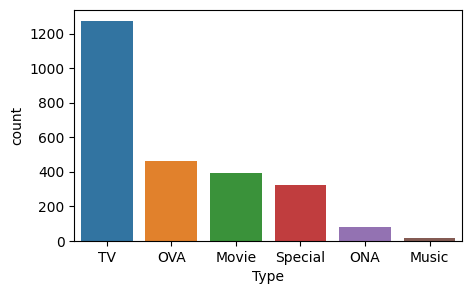

In [ ]:
#Countplot
plt.figure(figsize=(5,3))
sns.countplot(x=anime["Type"], order=type);

In [ ]:
# ordenar los tipos de anime por frecuencia
status = anime['Status'].value_counts().index.tolist()
status

['Finished Airing', 'Currently Airing']

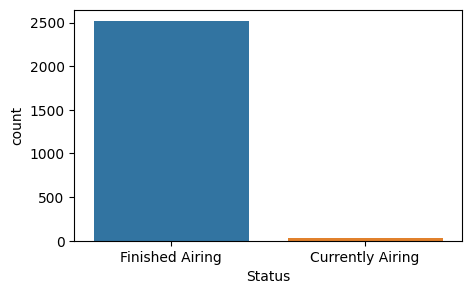

In [ ]:
#Countplot
plt.figure(figsize=(5,3))
sns.countplot(x=anime["Status"], order=status);

In [ ]:
# ordenar los tipos de anime por frecuencia. Hay 506 estudios diferentes. Ojo! "Studio Ghibli" está.
studio = anime['Studios'].value_counts().index.tolist()
studio

['Toei Animation',
 'TMS Entertainment',
 'Studio Deen',
 'Madhouse',
 'J.C.Staff',
 'Pierrot',
 'Sunrise',
 'Production I.G',
 'Shin-Ei Animation',
 'OLM',
 'A-1 Pictures',
 'Bones',
 'Xebec',
 'Nippon Animation',
 "Brain's Base",
 'Tatsunoko Production',
 'Shaft',
 'Tokyo Movie Shinsha',
 'AIC',
 'Gallop',
 'LIDENFILMS',
 'Gonzo',
 'MAPPA',
 'Production Reed',
 'Studio Comet',
 'Group TAC',
 'Shanghai Animation Film Studio',
 'Bandai Namco Pictures',
 'SILVER LINK.',
 'Wit Studio',
 'Zexcs',
 'Lerche',
 'Satelight',
 'Yumeta Company',
 'Hal Film Maker',
 'DLE',
 'SynergySP',
 'Polygon Pictures',
 'Manglobe',
 'Magic Bus',
 'Studio Gokumi',
 'AIC ASTA',
 'A.C.G.T.',
 'Ajia-Do',
 'David Production',
 'Doga Kobo',
 'Telecom Animation Film',
 'Artland',
 'Hoods Entertainment',
 'Tezuka Productions',
 'Eiken',
 'Gainax',
 'Actas',
 'Mushi Production',
 'Seven',
 'asread.',
 'Radix',
 'Platinum Vision',
 'Studio Hibari',
 'Gathering',
 'TYO Animations',
 'Arms',
 'Production I.G, Xebec',
 

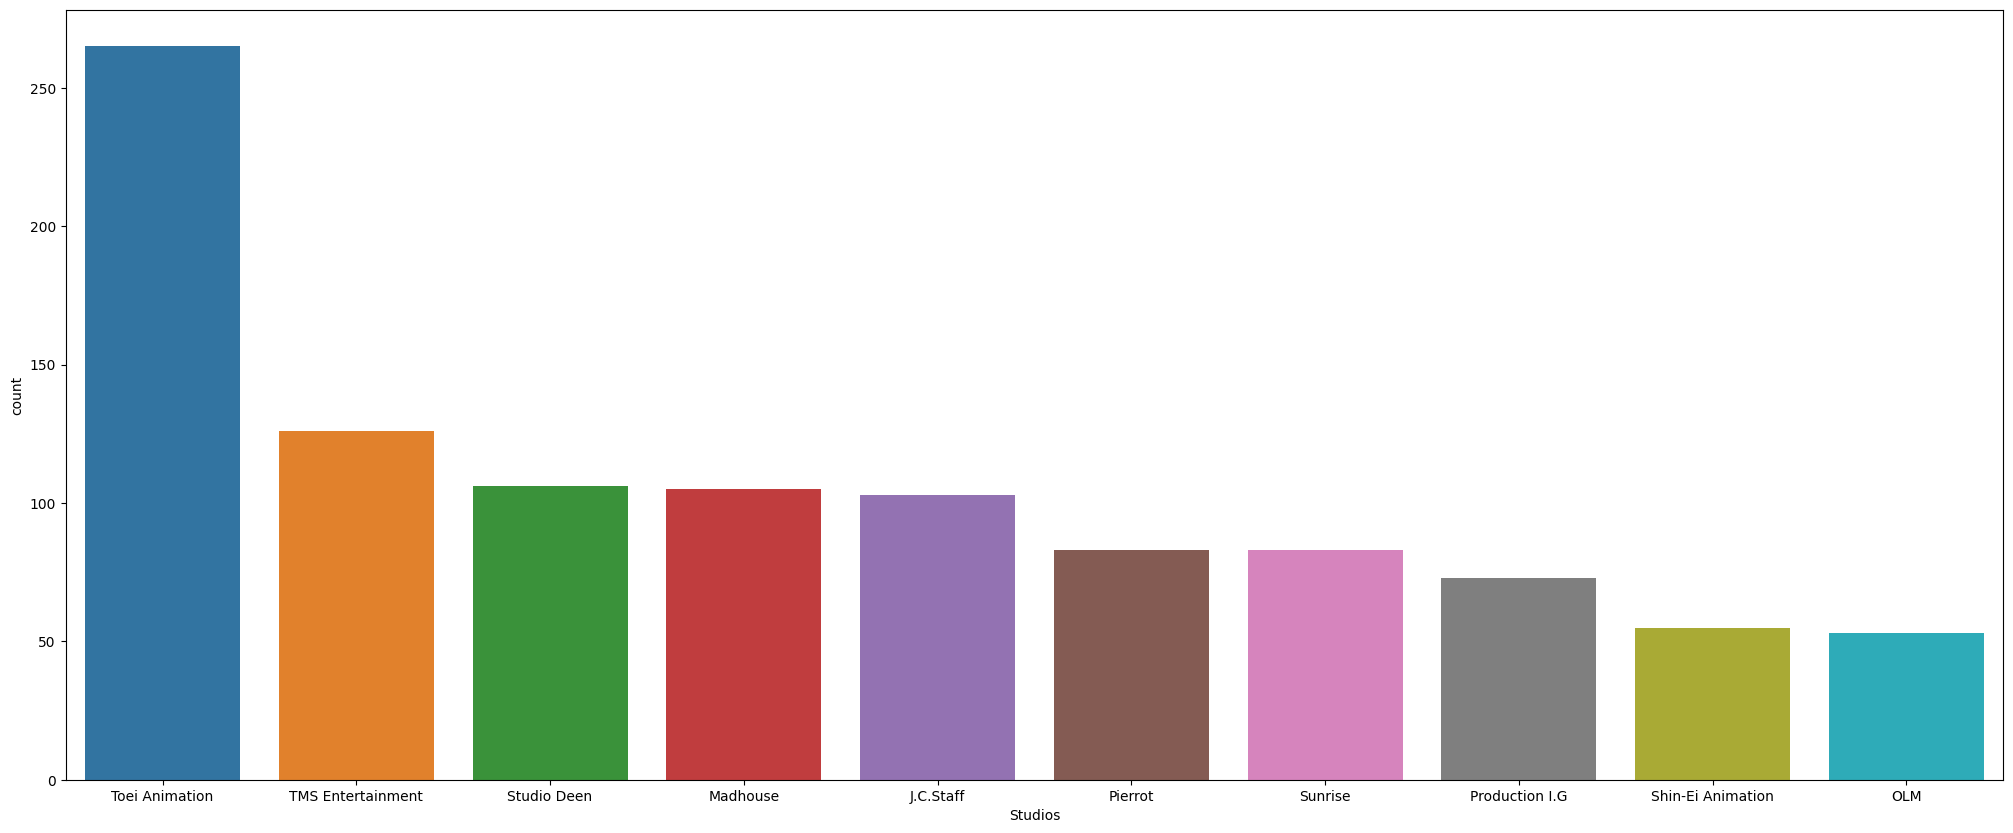

In [ ]:
#Countplot
#Son demasiados estudios (506), mejor que muestre los 10 primeros. Probé con 50 y con 20. No se leen las etiquetas
plt.figure(figsize=(25,10))
sns.countplot(x=anime["Studios"], order=studio[:10],dodge=True);

In [ ]:
# ordenar los tipos de anime por frecuencia.
source = anime['Source'].value_counts().index.tolist()
source

['Manga',
 'Original',
 'Unknown',
 'Game',
 '4-koma manga',
 'Visual novel',
 'Novel',
 'Light novel',
 'Other',
 'Web manga',
 'Picture book',
 'Card game',
 'Book',
 'Mixed media']

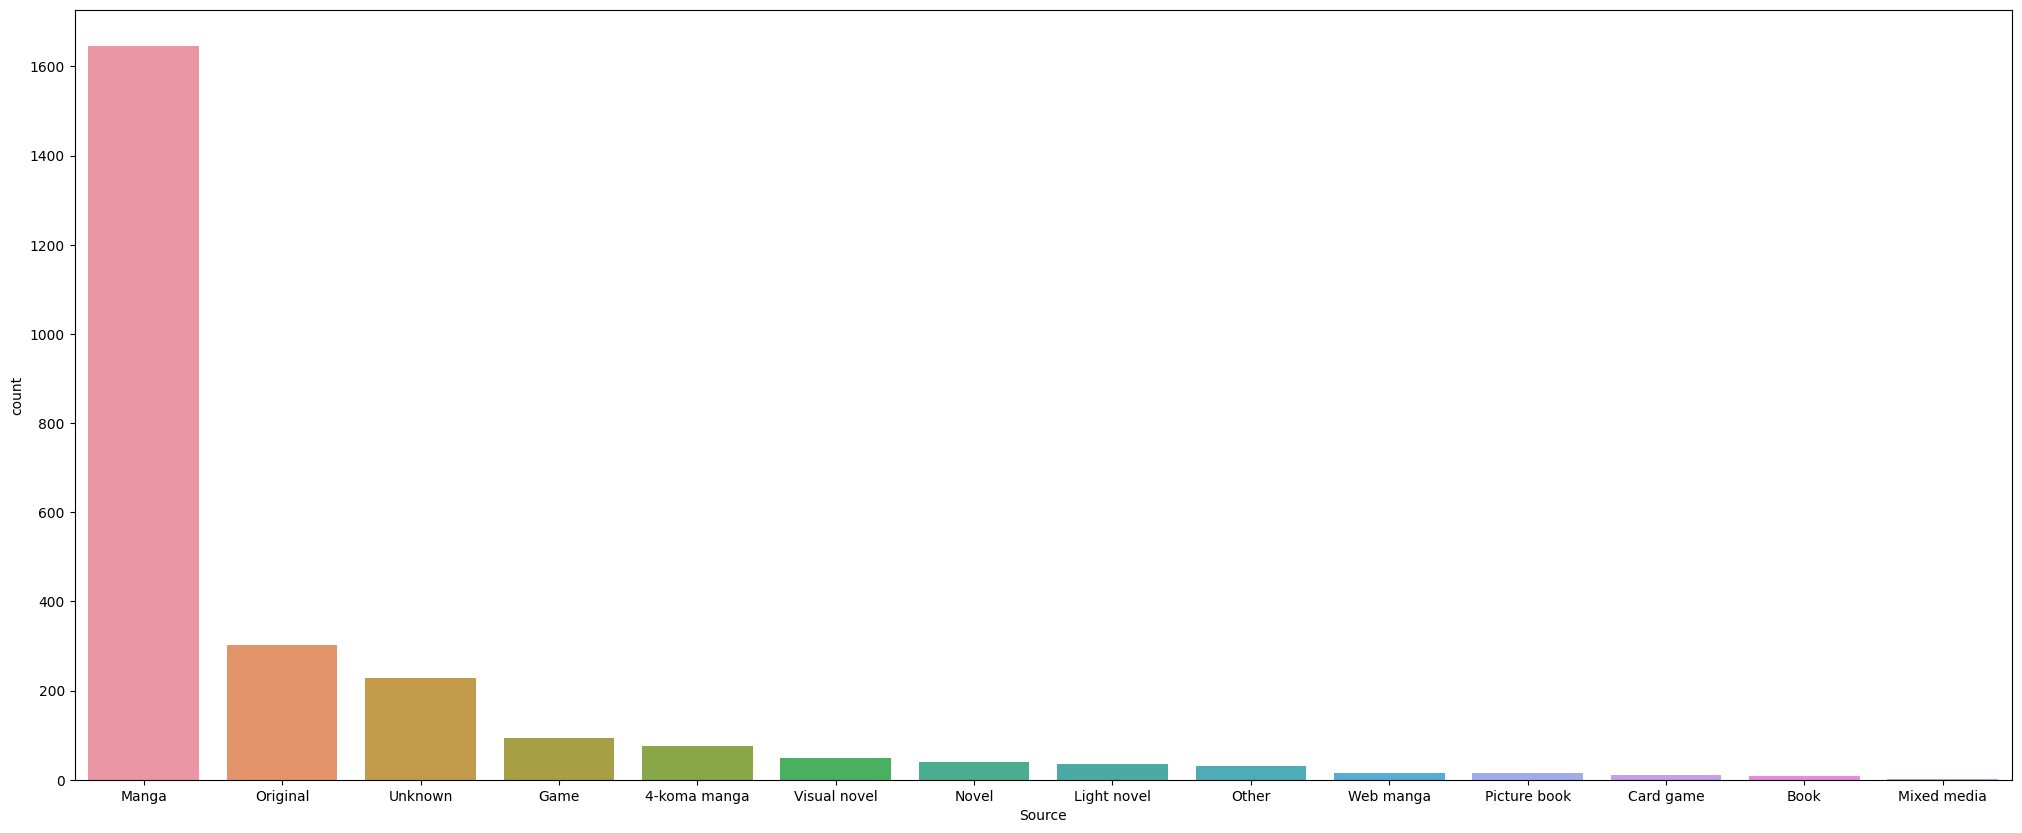

In [ ]:
#Countplot
plt.figure(figsize=(25,10))
sns.countplot(x=anime["Source"], order=source);

In [ ]:
# ordenar los tipos de anime por frecuencia.
genres = anime['Genres'].value_counts().index.tolist()
genres

['Action',
 'Comedy',
 'Adventure',
 'Drama',
 'Sports',
 'Fantasy',
 'Romance',
 'Slice of Life',
 'Sci-Fi',
 'Mystery',
 'Supernatural',
 'Gourmet',
 'Horror',
 'Boys Love',
 'Suspense',
 'Ecchi',
 'Girls Love',
 'Avant Garde']

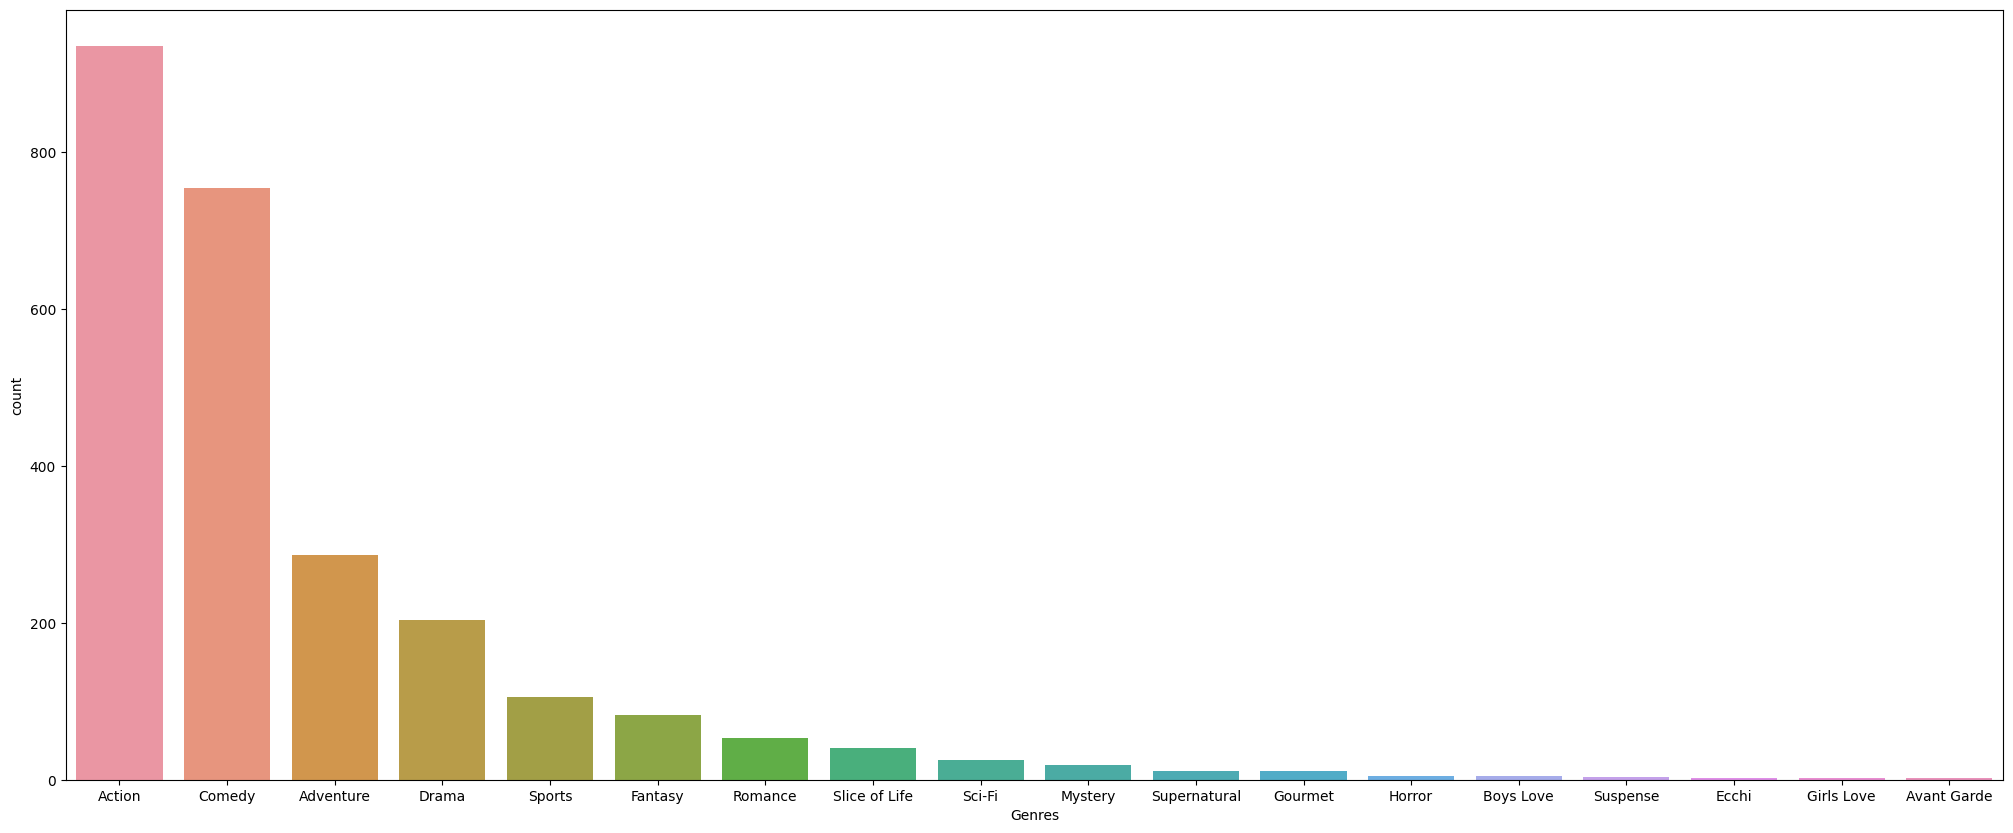

In [ ]:
#Countplot
plt.figure(figsize=(25,10))
sns.countplot(x=anime["Genres"], order=genres);

In [ ]:
# ordenar los tipos de anime por frecuencia.
themes = anime['Themes'].value_counts().index.tolist()
themes

['School',
 'Historical',
 'Mecha',
 'Adult Cast',
 'Mythology',
 'Mahou Shoujo',
 'Martial Arts',
 'Harem',
 'Super Power',
 'Gag Humor',
 'Detective',
 'Team Sports',
 'Anthropomorphic',
 'Combat Sports',
 'Iyashikei',
 'Strategy Game',
 'Music',
 'Gore',
 'Idols',
 'Parody',
 'CGDCT',
 'Psychological',
 'Racing',
 'Military',
 'Isekai',
 'Space',
 'Delinquents',
 'Vampire',
 'Love Polygon',
 'Childcare',
 'Educational',
 'Pets',
 'Reverse Harem',
 'Otaku Culture',
 'Magical Sex Shift',
 'Romantic Subtext',
 'Workplace',
 'Organized Crime',
 'Performing Arts',
 'High Stakes Game',
 'Crossdressing',
 'Time Travel',
 'Samurai',
 'Visual Arts',
 'Survival',
 'Reincarnation',
 'Showbiz',
 'Medical',
 'Video Game']

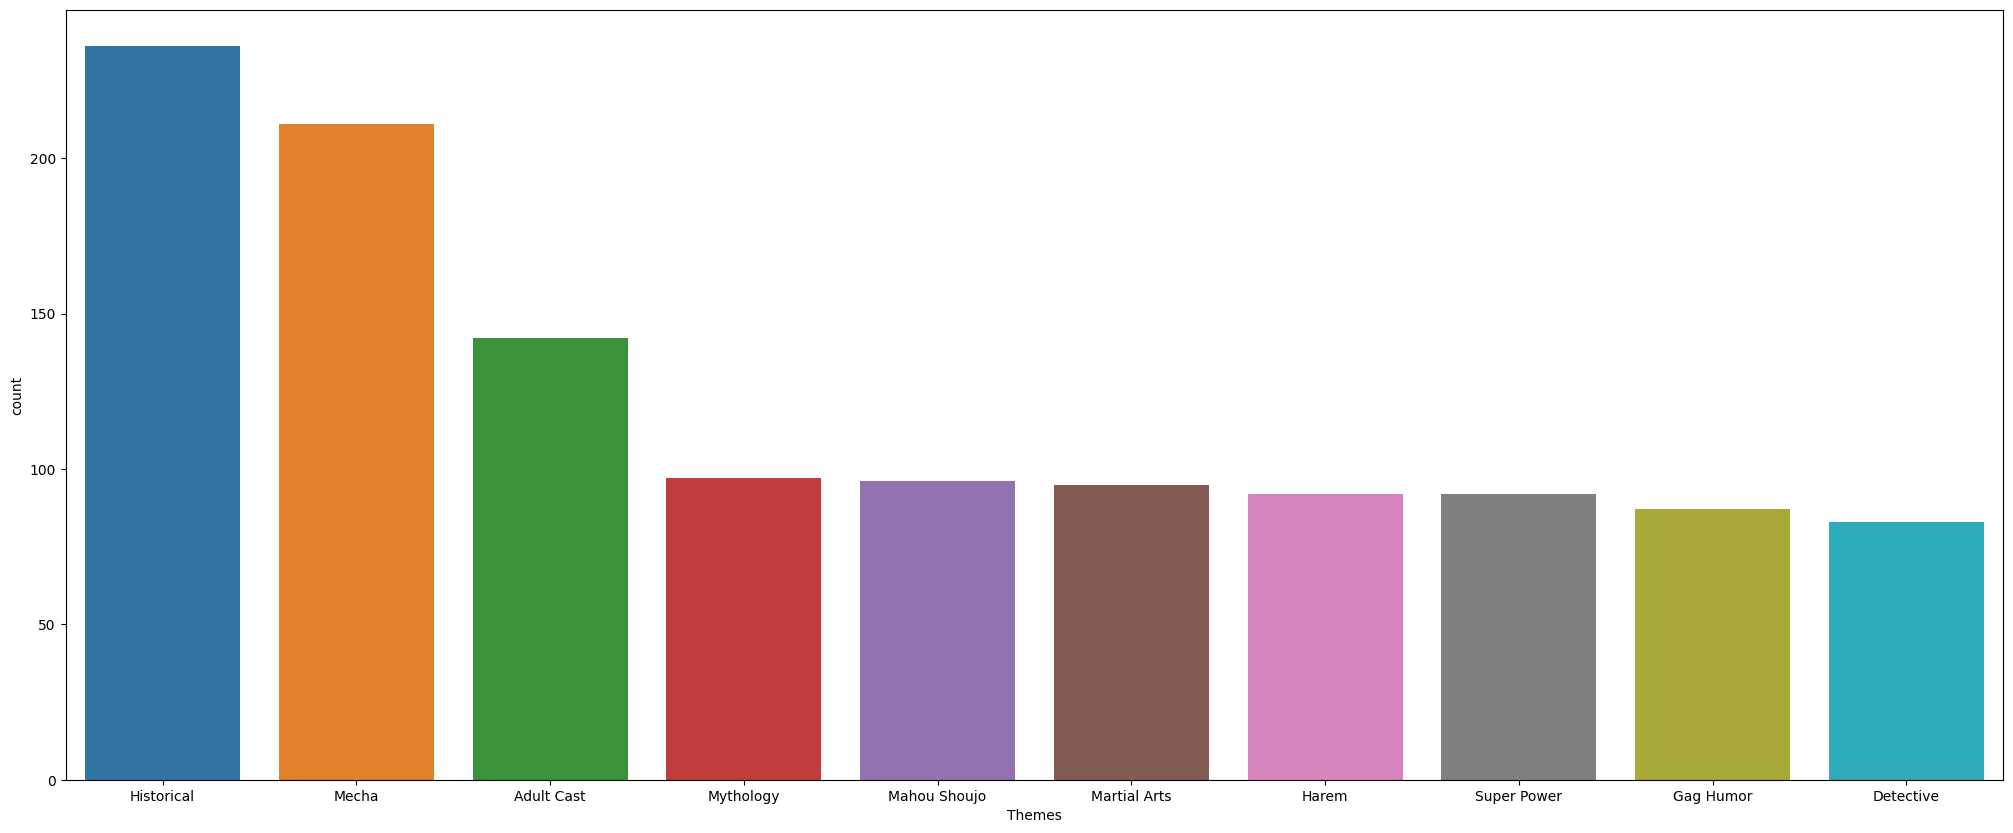

In [ ]:
#Countplot. Tiene + de 20 categorías y la cantidad de Unknowns es muy elevada. Mostramos sin Unknown y lo 10 primeros
plt.figure(figsize=(25,10))
sns.countplot(x=anime["Themes"], order=themes[1:11]);

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2548 entries, 0 to 21182
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2548 non-null   object 
 1   English           2548 non-null   object 
 2   Type              2548 non-null   object 
 3   Episodes          2548 non-null   float64
 4   Status            2548 non-null   object 
 5   Start_Aired       2548 non-null   int64  
 6   Studios           2548 non-null   object 
 7   Source            2548 non-null   object 
 8   Genres            2548 non-null   object 
 9   Themes            2548 non-null   object 
 10  Demographics      2548 non-null   object 
 11  Duration_Minutes  2548 non-null   float64
 12  Rating            2548 non-null   object 
 13  Score             2548 non-null   float64
 14  Scored_Users      2548 non-null   float64
 15  Ranked            2548 non-null   float64
dtypes: float64(5), int64(1), object(10)
memor

In [ ]:
#Frecuencia en columna concreta
demog = anime["Demographics"].value_counts().index.tolist()
demog

['Shounen', 'Seinen', 'Shoujo', 'Kids', 'Josei']

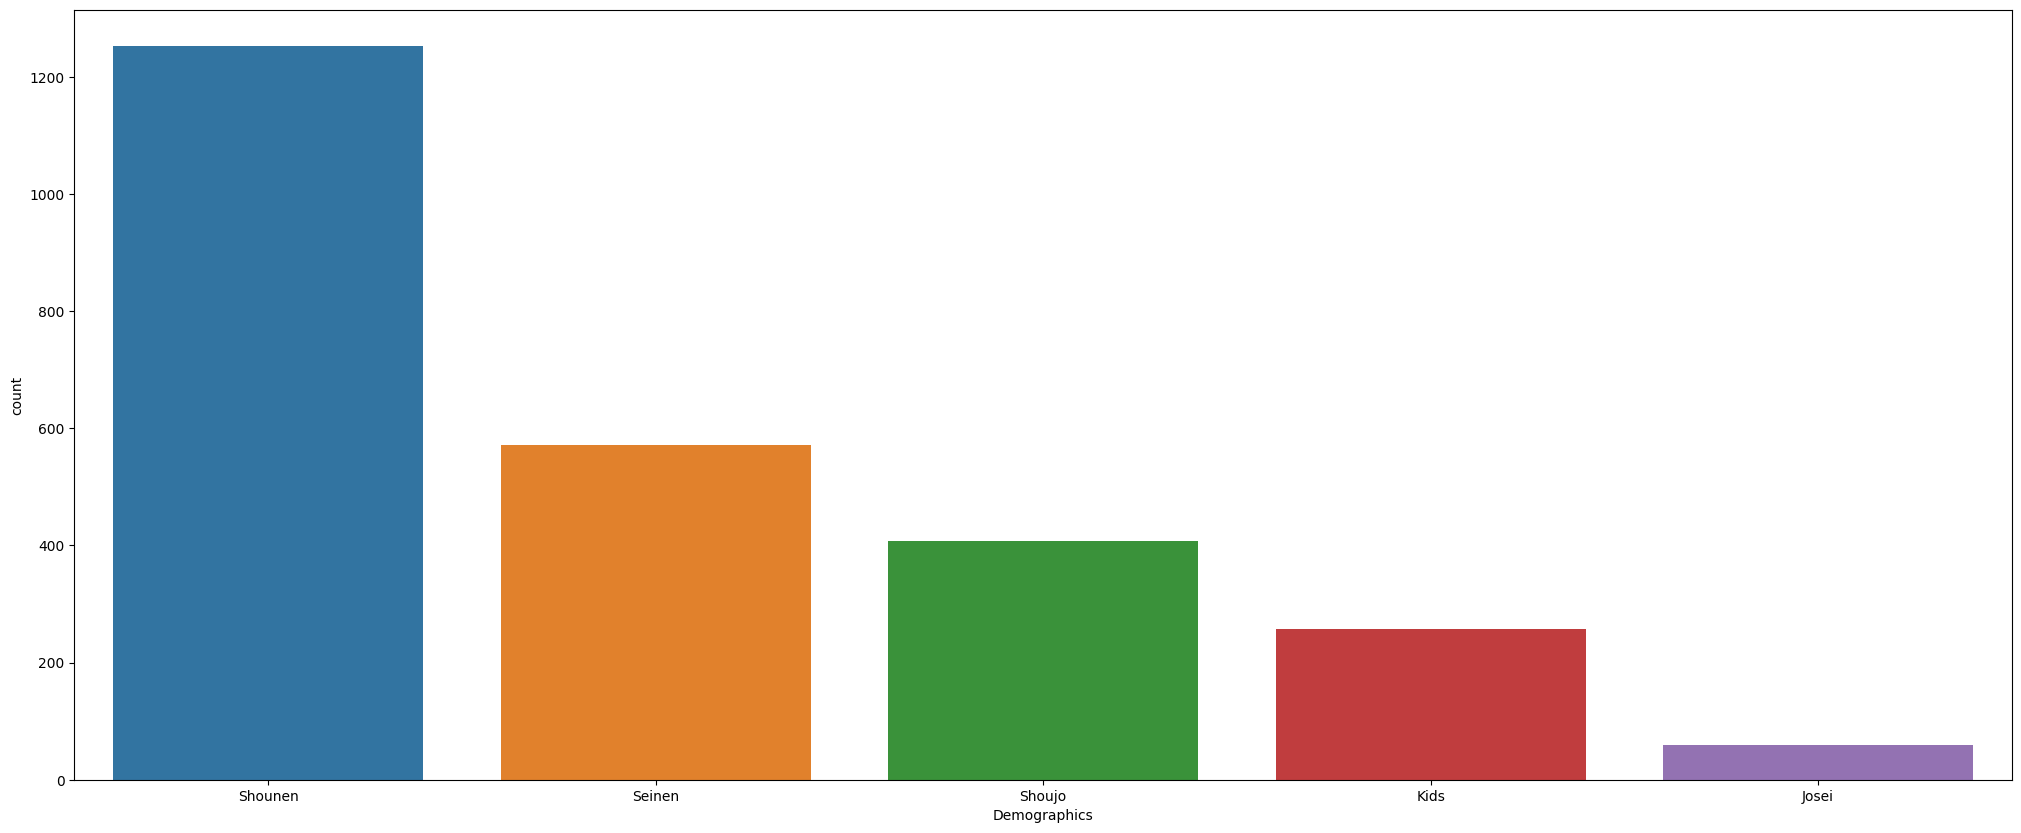

In [ ]:
#Countplot
plt.figure(figsize=(25,10))
sns.countplot(x=anime["Demographics"], order=demog);

In [ ]:
rating =anime["Rating"].value_counts().index.tolist()
rating

['PG-13 - Teens 13 or older',
 'G - All Ages',
 'R - 17+ (violence & profanity)',
 'PG - Children',
 'R+ - Mild Nudity',
 'None']

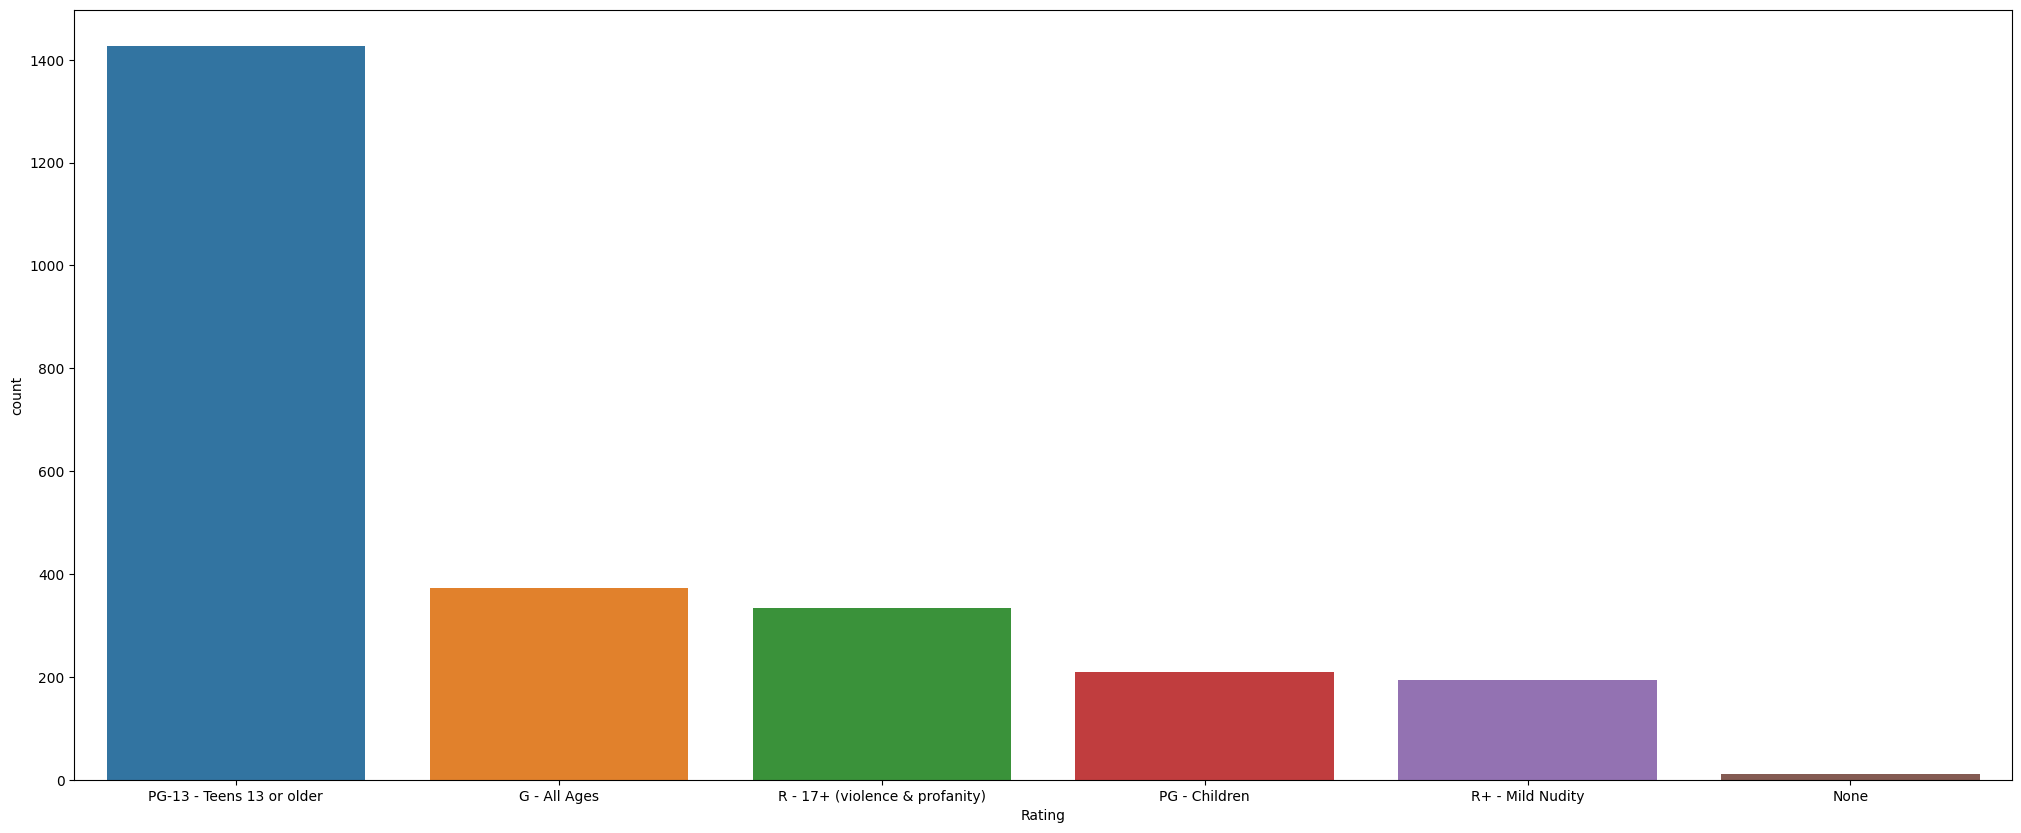

In [ ]:
#countplot
plt.figure(figsize=(25,10))
sns.countplot(x=anime["Rating"], order=rating);

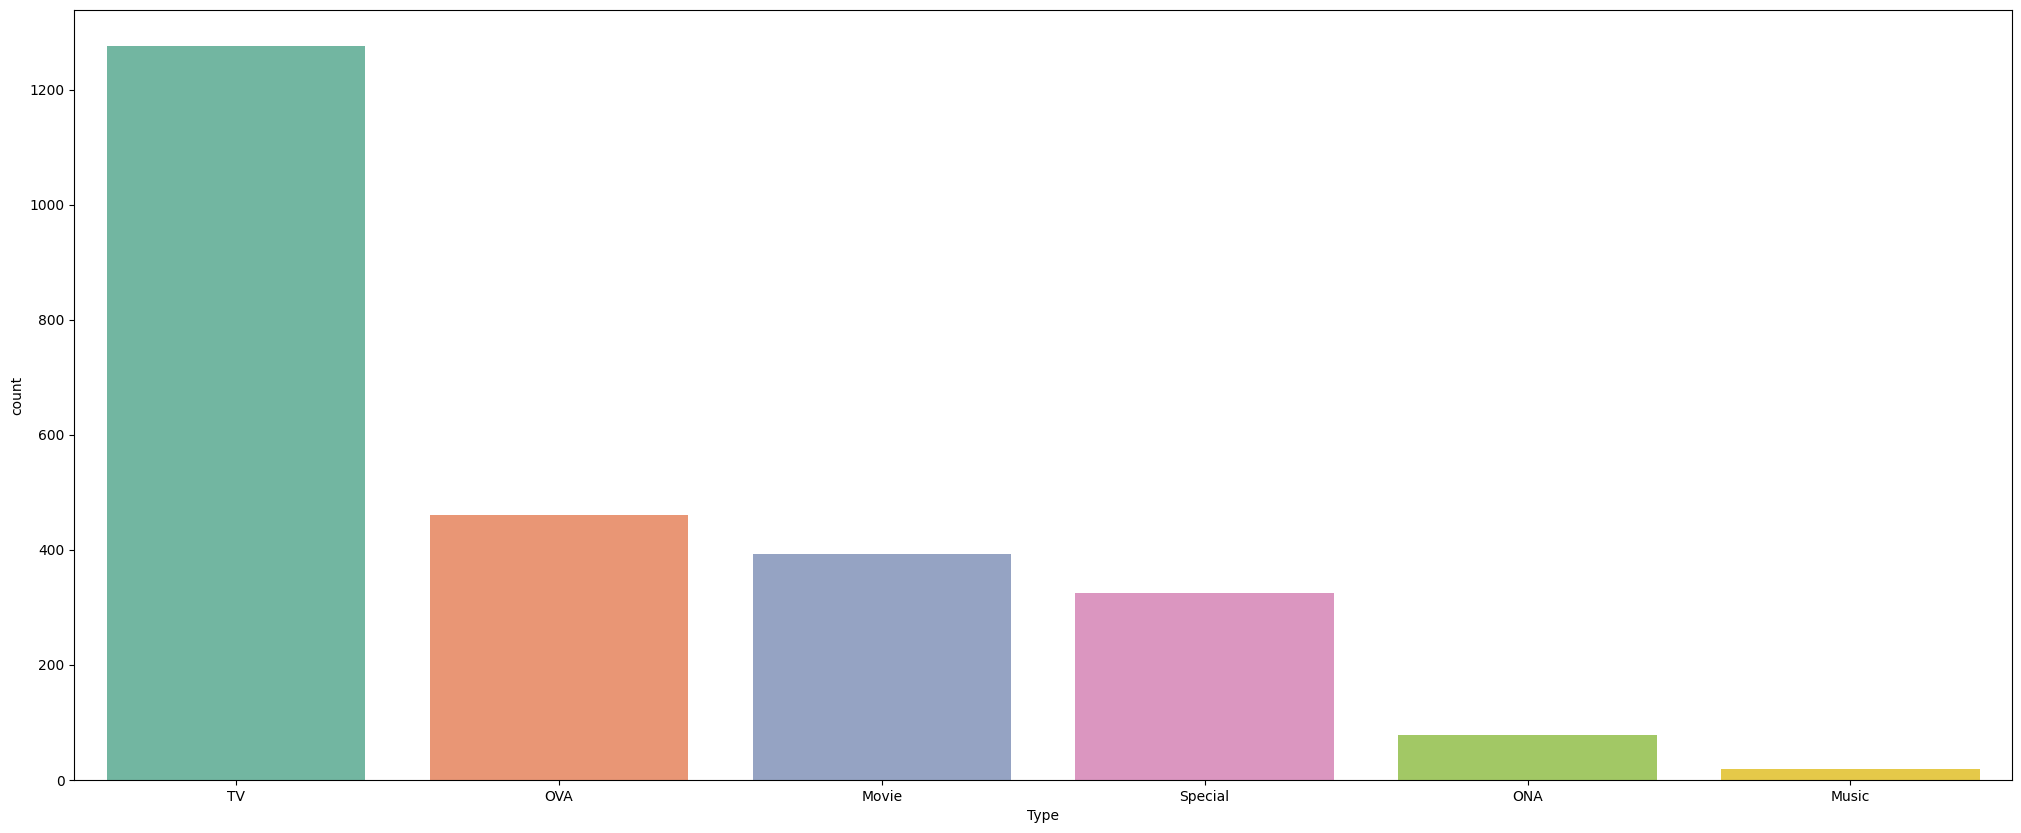

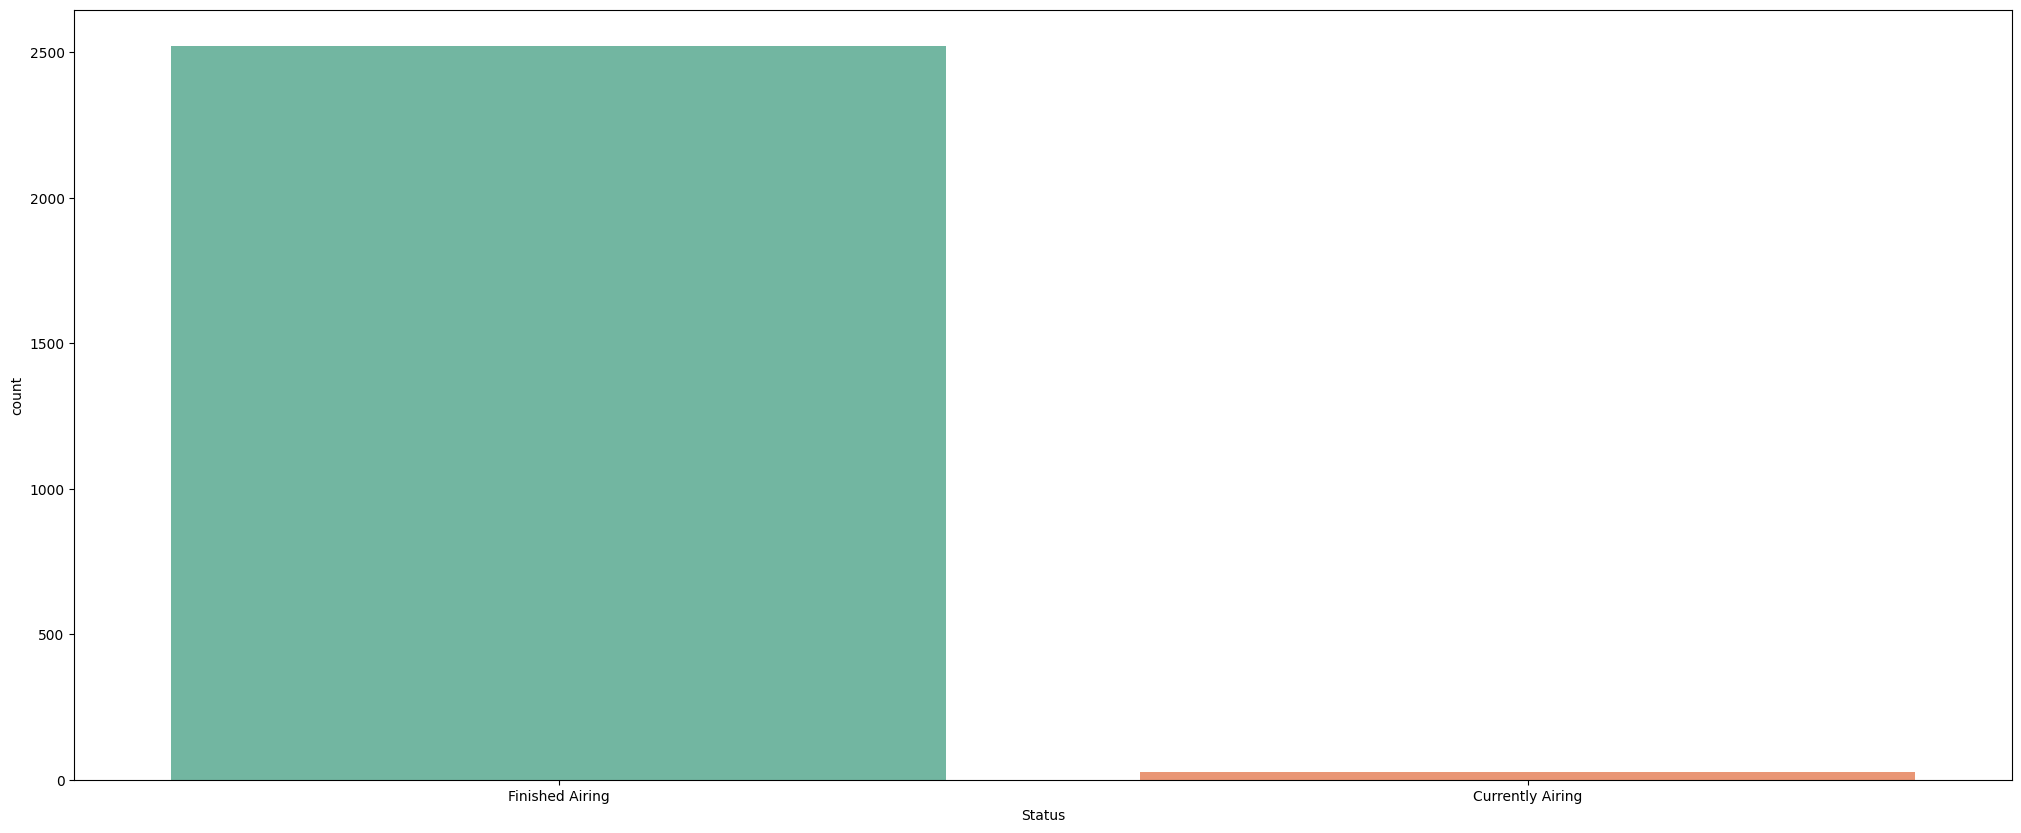

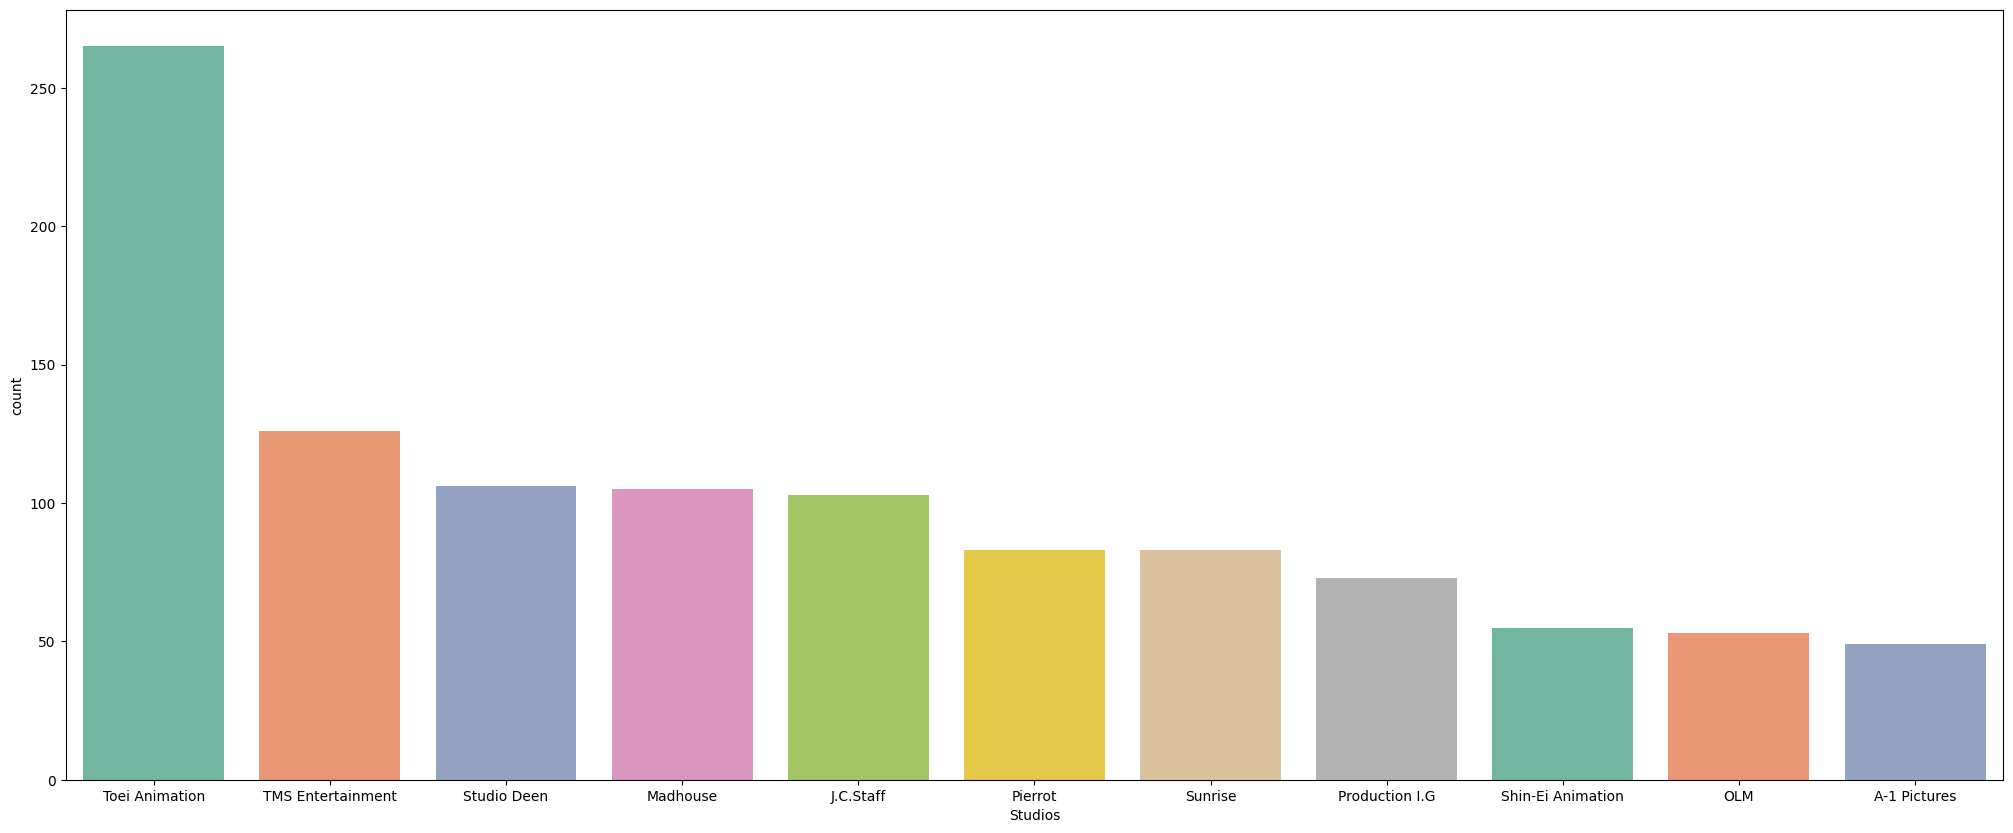

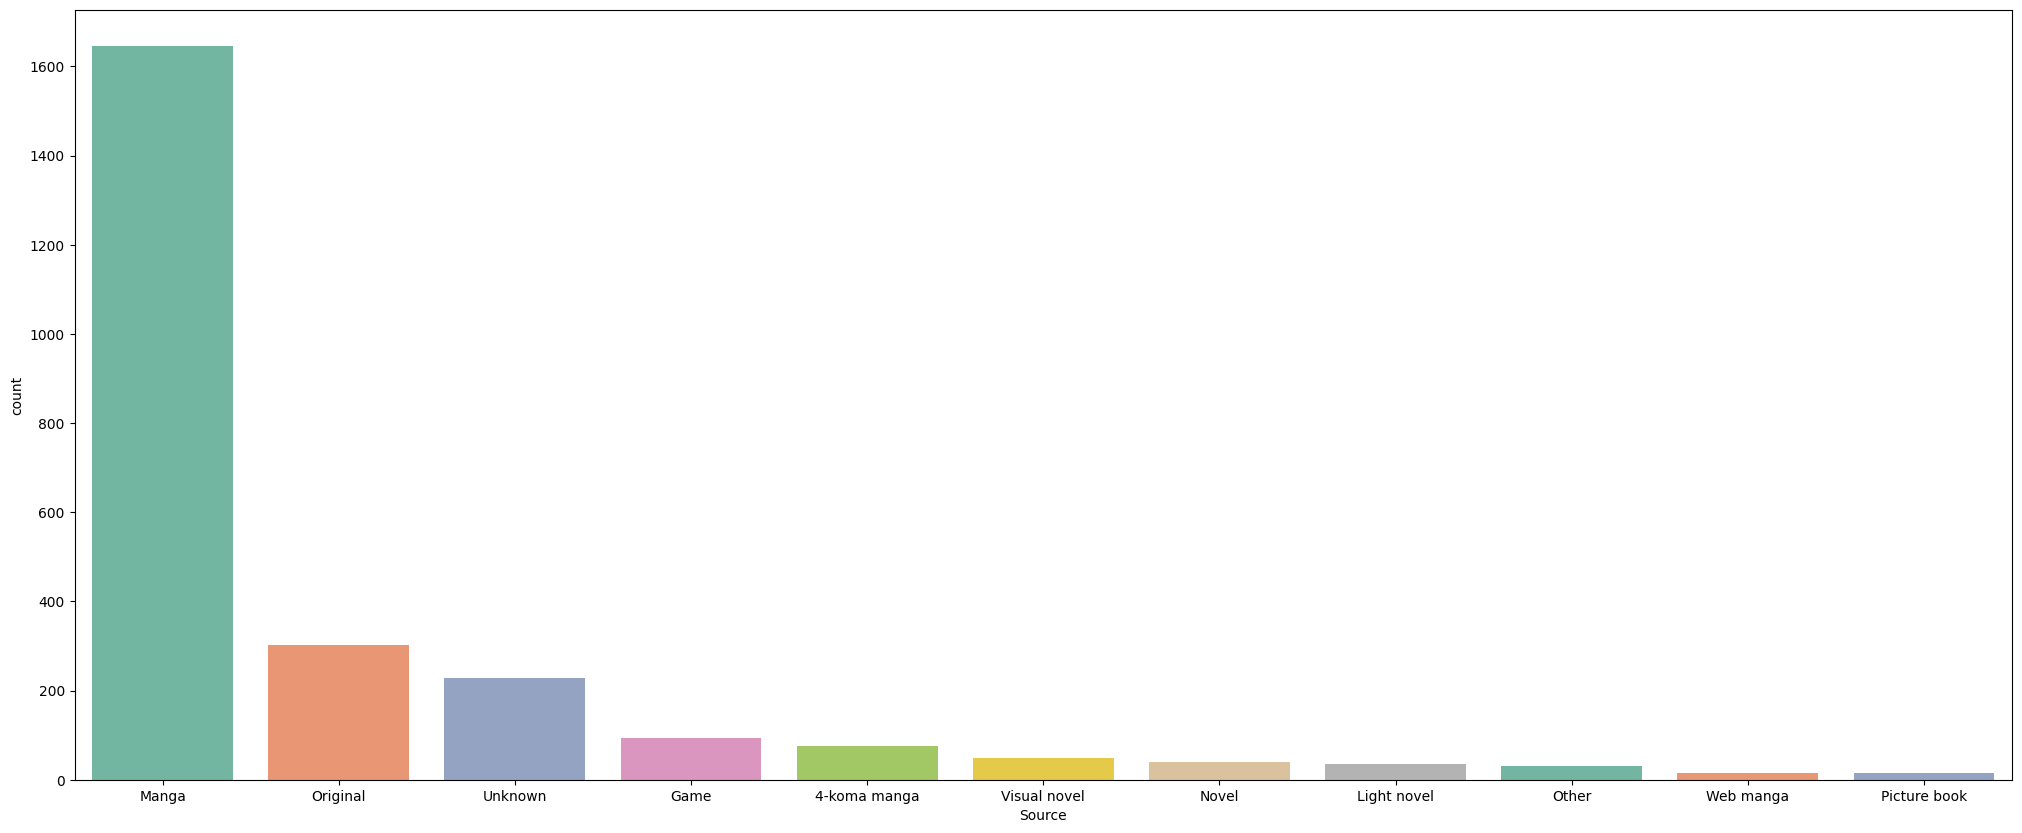

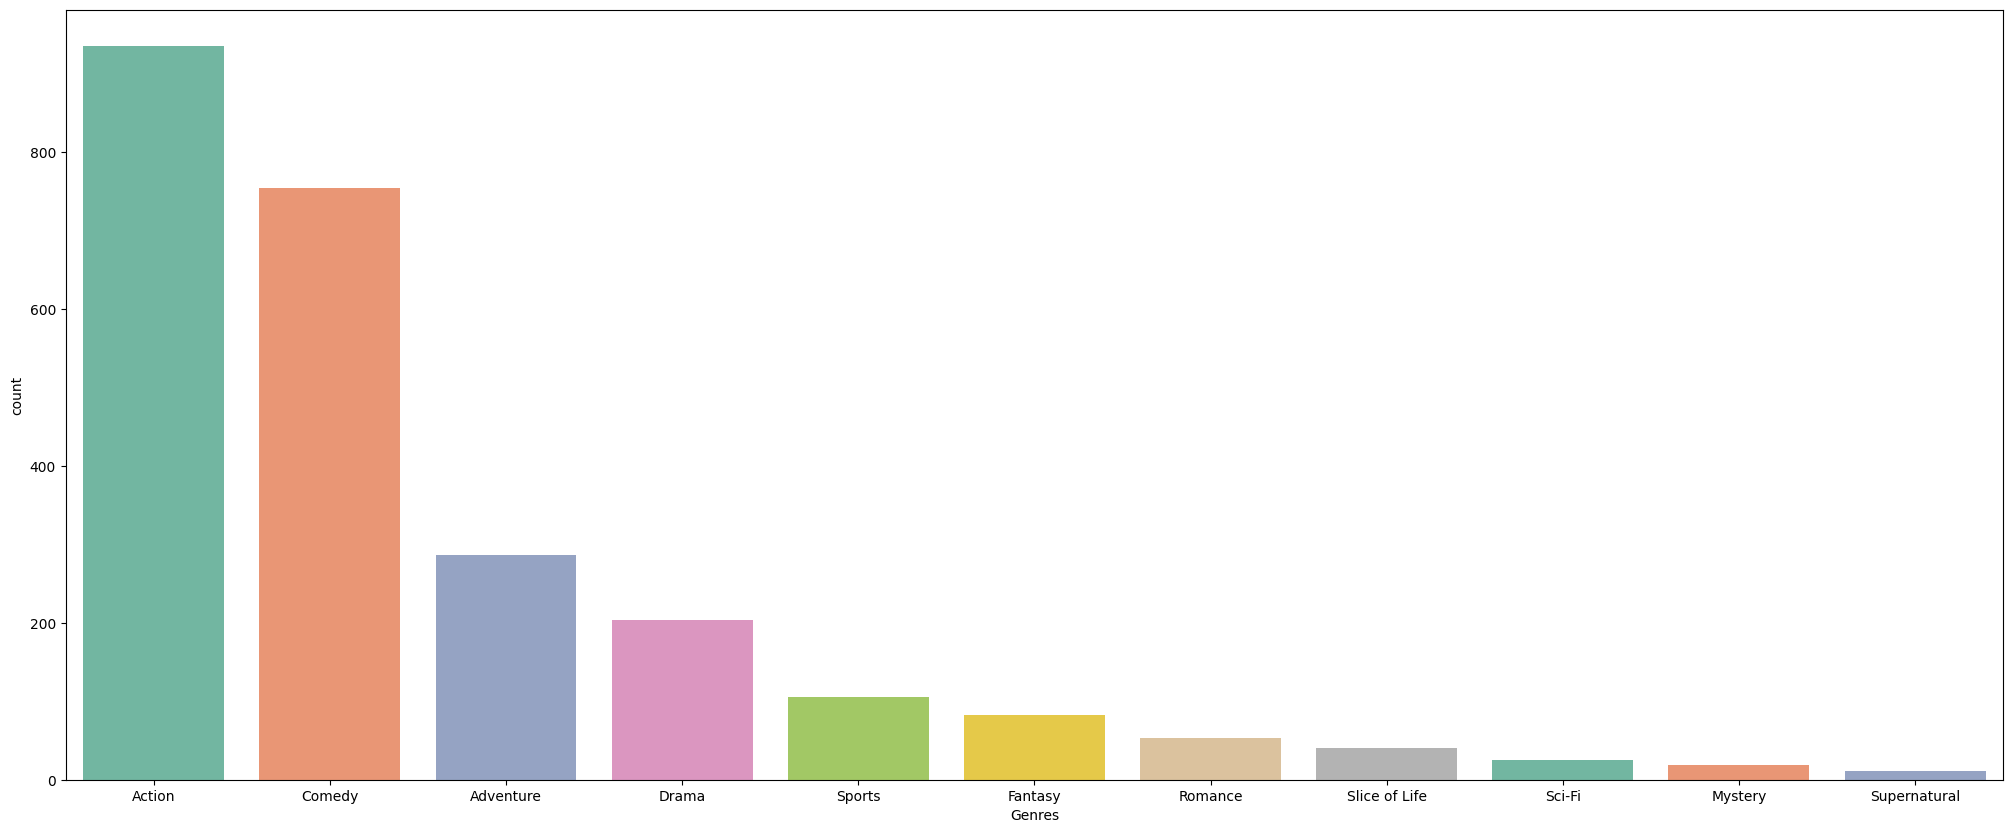

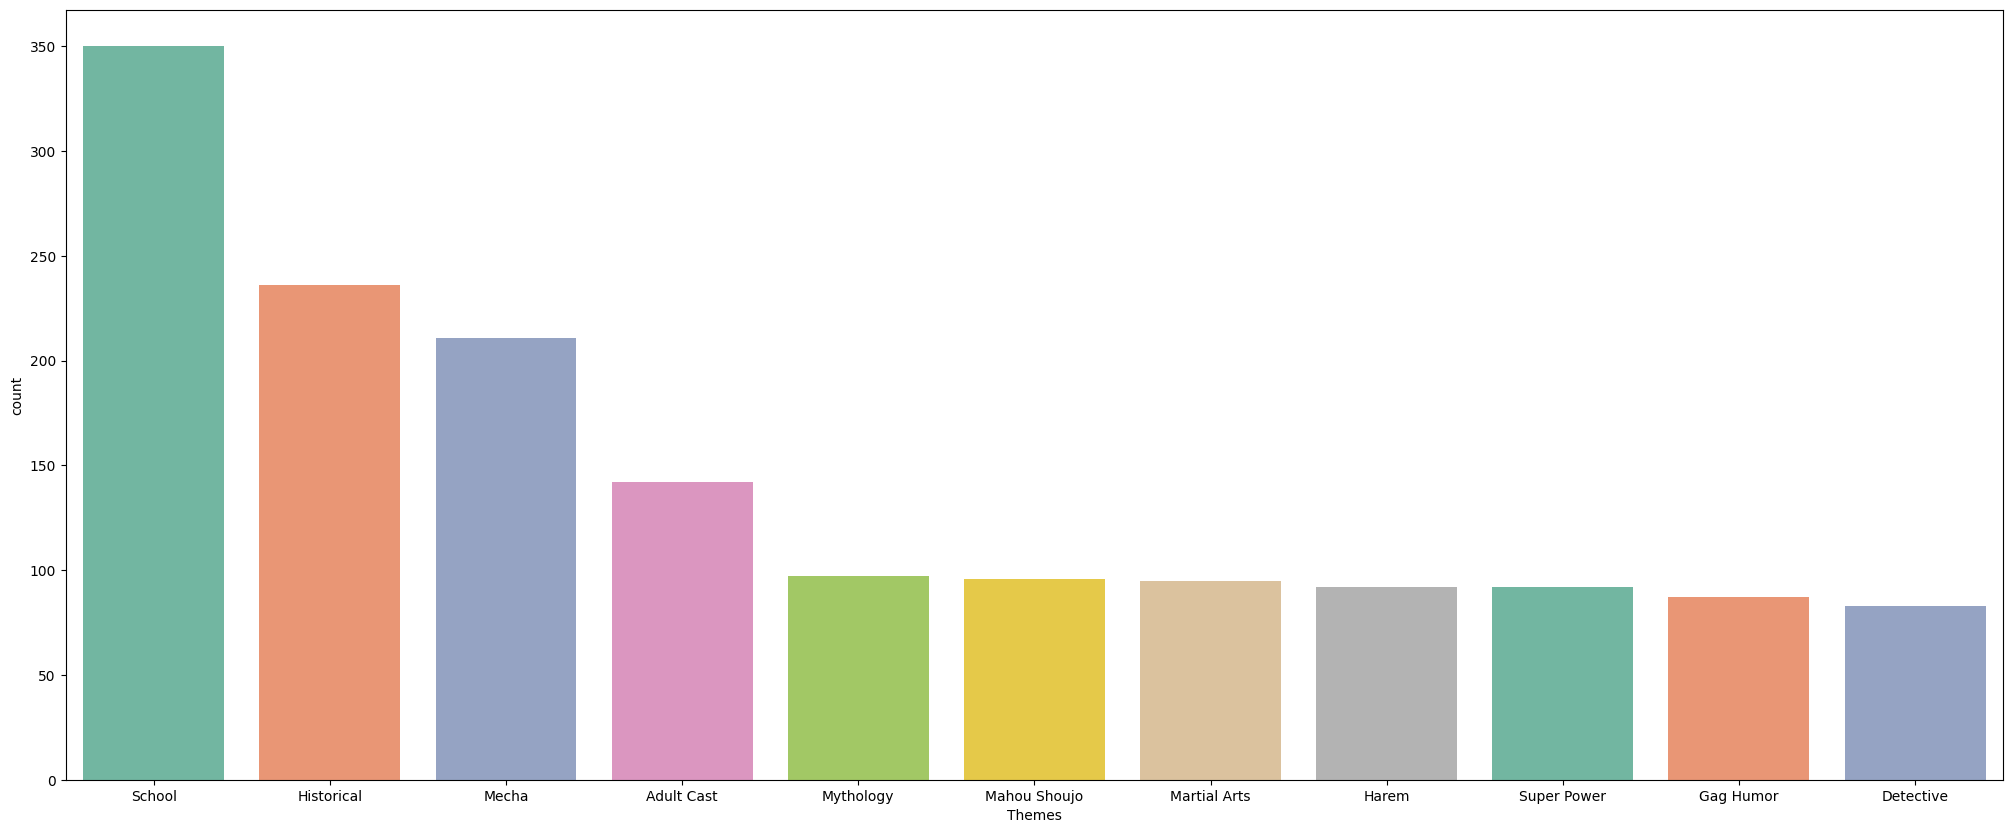

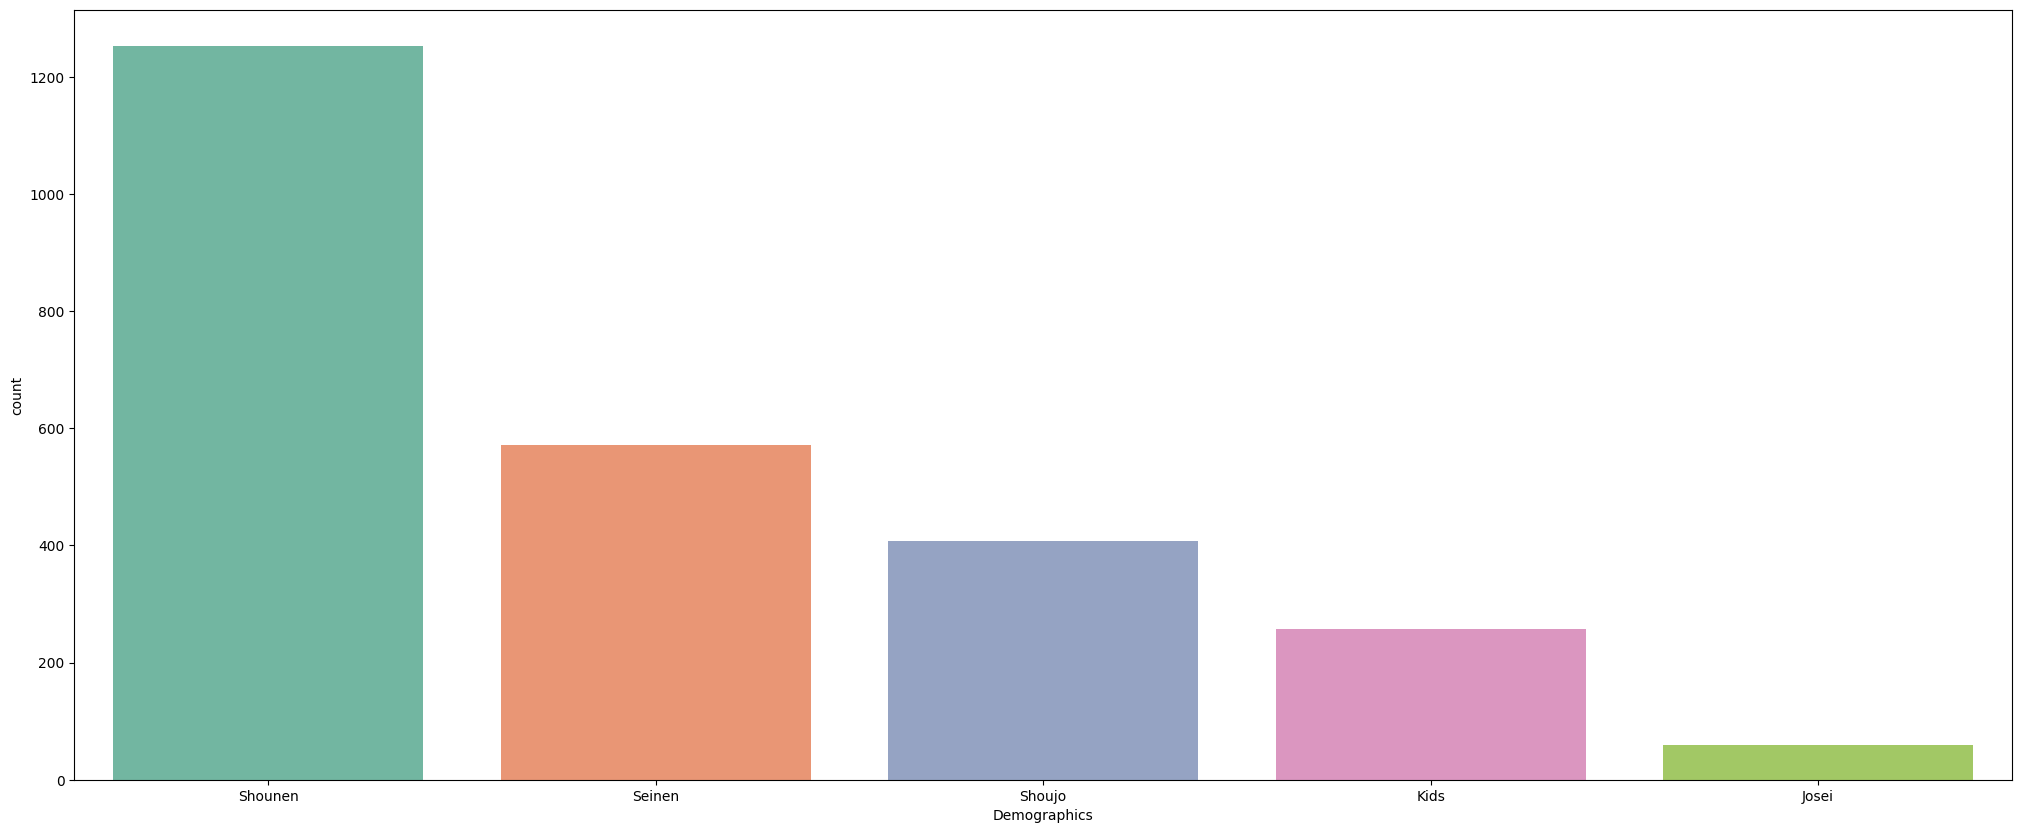

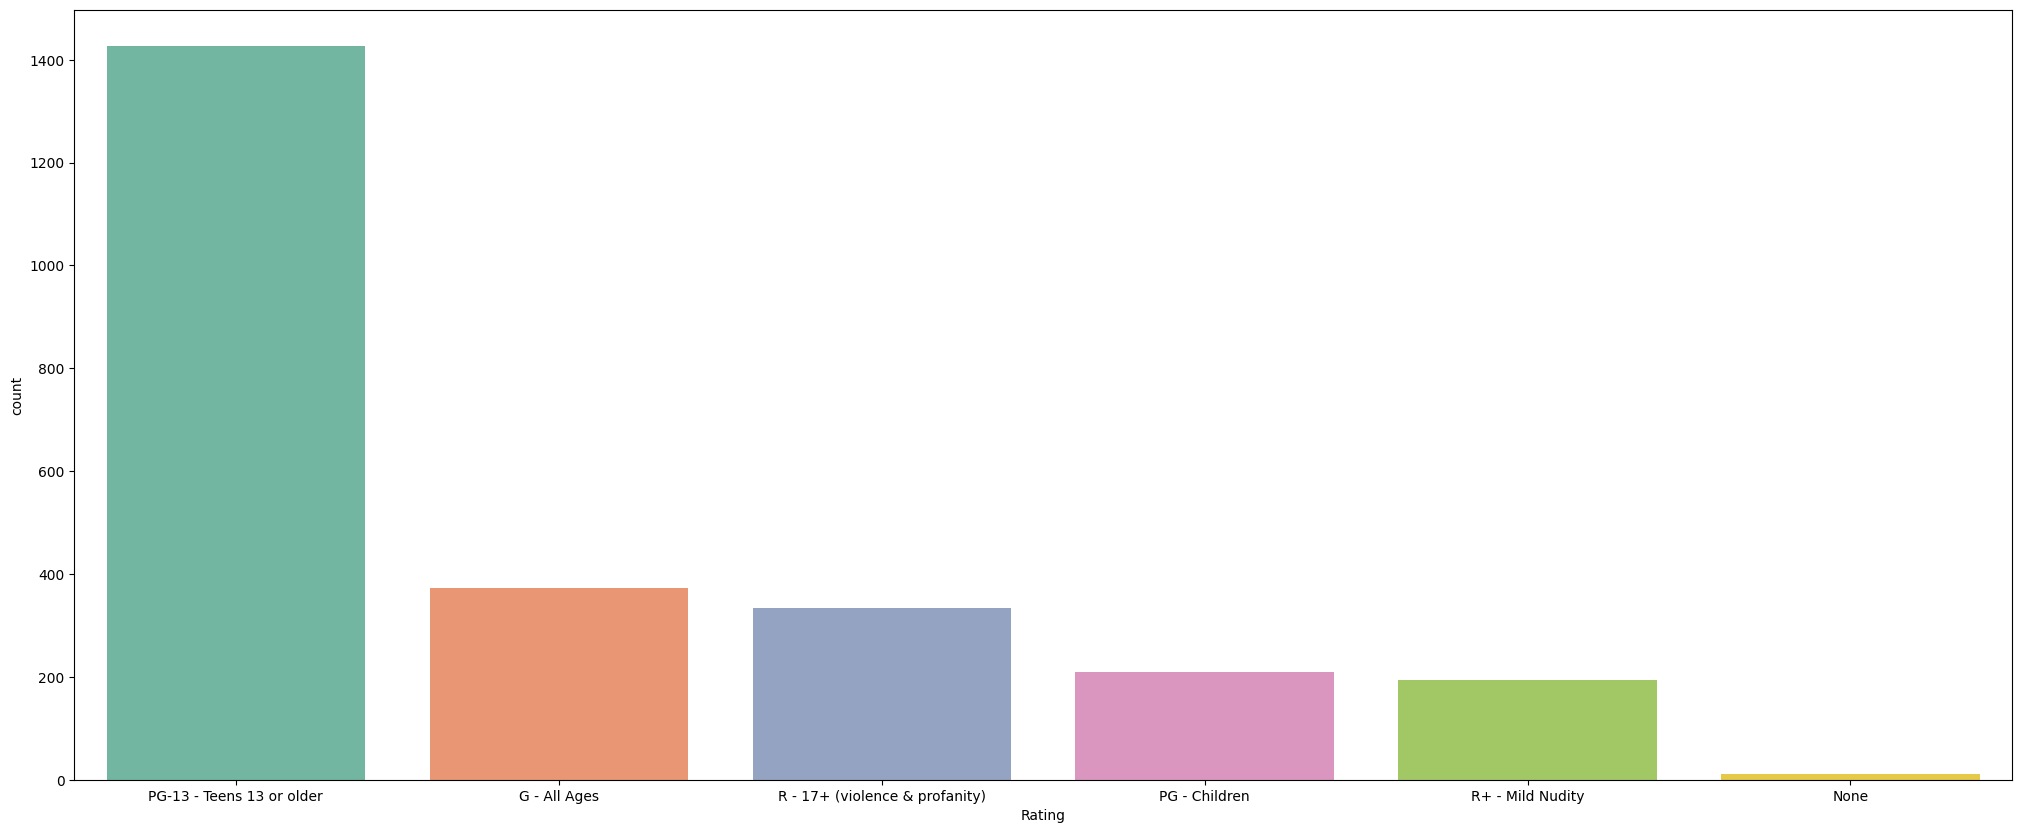

In [ ]:
#Intentemos hacer una función que nos haga todos los countplots de una vez:
#Creo una variable que contenga las columnas del dataframe que sean object. Creo otra que me excluya las 2 variables que no quiero que
#haga countplot por un valor distinto en cada fila.
cuant_col = anime.select_dtypes(include=['object'])
exclude_cols = ["Title", "English", "Start_Aired"]

#Creo un bucle que me recorra todas esas columnas, me las ordene por frecuencia y genere un countplot por cada columna.

for col in cuant_col:
    if col not in exclude_cols:
        order = cuant_col[col].value_counts().index.tolist()
        plt.figure(figsize=(25,10))
        sns.countplot(x=cuant_col[col], order=order[:11], palette="Set2");
        # ax.set_title(col) #Título de la gráfica. No aplica en este caso porque ya está en el eje de abajo
    else:
        pass


Variables cuantitativas

In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2548 entries, 0 to 21182
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2548 non-null   object 
 1   English           2548 non-null   object 
 2   Type              2548 non-null   object 
 3   Episodes          2548 non-null   float64
 4   Status            2548 non-null   object 
 5   Start_Aired       2548 non-null   int64  
 6   Studios           2548 non-null   object 
 7   Source            2548 non-null   object 
 8   Genres            2548 non-null   object 
 9   Themes            2548 non-null   object 
 10  Demographics      2548 non-null   object 
 11  Duration_Minutes  2548 non-null   float64
 12  Rating            2548 non-null   object 
 13  Score             2548 non-null   float64
 14  Scored_Users      2548 non-null   float64
 15  Ranked            2548 non-null   float64
dtypes: float64(5), int64(1), object(10)
memor

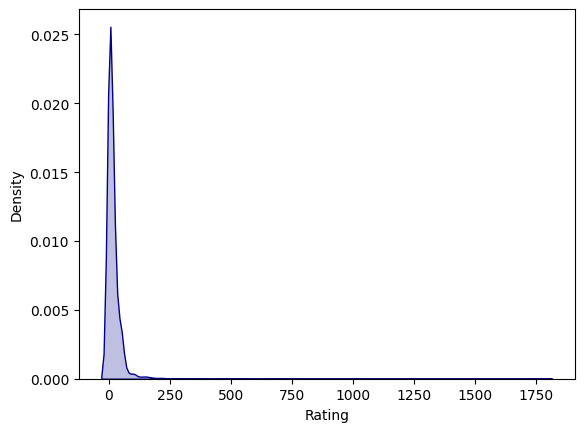

In [ ]:
#Densidad de columna Episodes
sns.kdeplot(anime["Episodes"], shade=True, color='darkblue')
plt.xlabel(col)
plt.show()

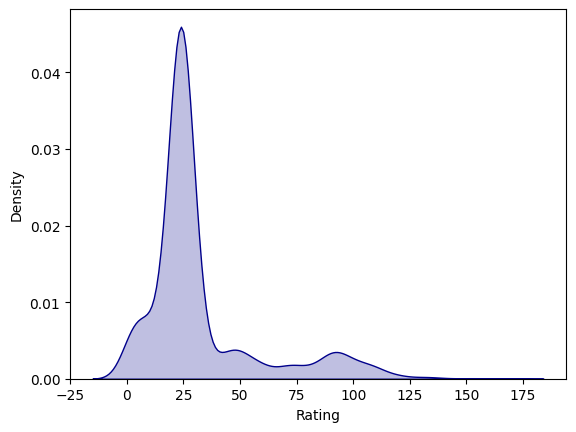

In [ ]:
#Densidad de columna Duration_minutes
sns.kdeplot(anime["Duration_Minutes"], shade=True, color='darkblue')
plt.xlabel(col)
plt.show()

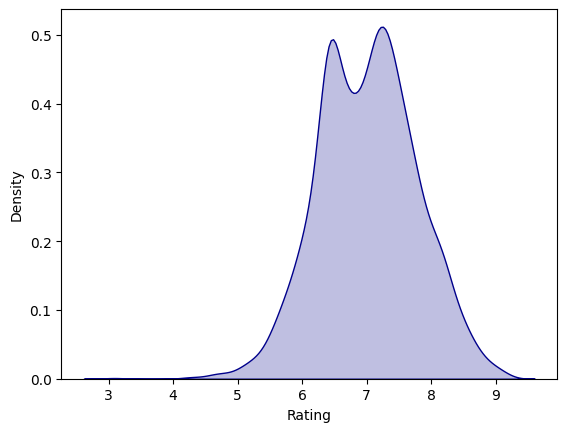

In [ ]:
#Densidad de columna Score
sns.kdeplot(anime["Score"], shade=True, color='darkblue')
plt.xlabel(col)
plt.show()

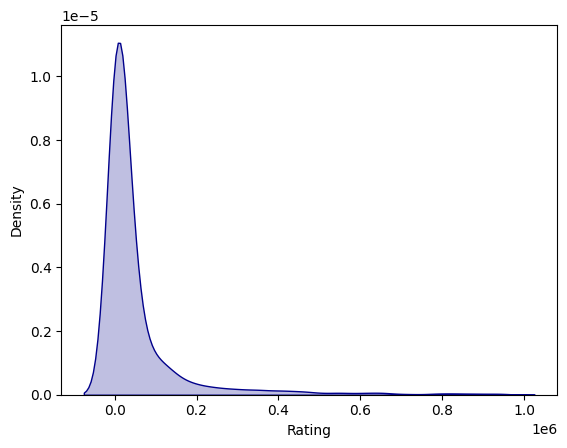

In [ ]:
#Densidad de columna Scored_Users
sns.kdeplot(anime["Scored_Users"], shade=True, color='darkblue')
plt.xlabel(col)
plt.show()

In [ ]:
# No refleja valores reales. Cómo puedo cambiar la distribución numérica del eje de la x? Por ejemplo. NO tiene sentido que esté entre 0 y 1 
# si el primer anime tiene un "Scored_Users" de 519803.0?. Busco info sobre el distplot y me dice que está obsoleto y que en
#la próxima versión de Python va a llamarse de otra forma.
anime["Scored_Users"].head()

0    519803.0
1    485487.0
2    900398.0
3     19066.0
5    871325.0
Name: Scored_Users, dtype: float64

In [ ]:
anime["Start_Aired"]

0        2013
1        2006
2        2009
3        2015
5        2016
         ... 
21058    2002
21060    1998
21118    2003
21158    2001
21182    2001
Name: Start_Aired, Length: 2548, dtype: int64

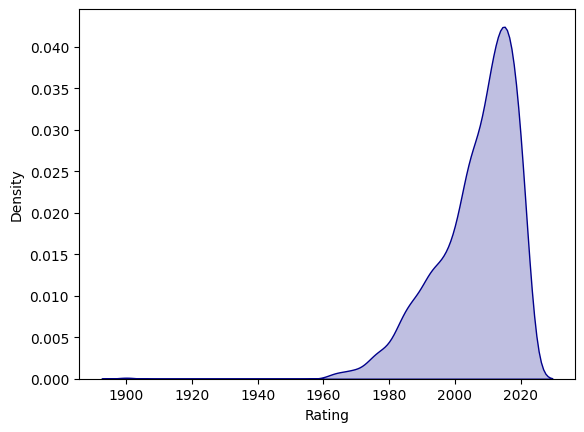

In [ ]:
#Densidad de columna "Start_Aired"
sns.kdeplot(anime["Start_Aired"], shade=True, color='darkblue')
plt.xlabel(col)
plt.show()

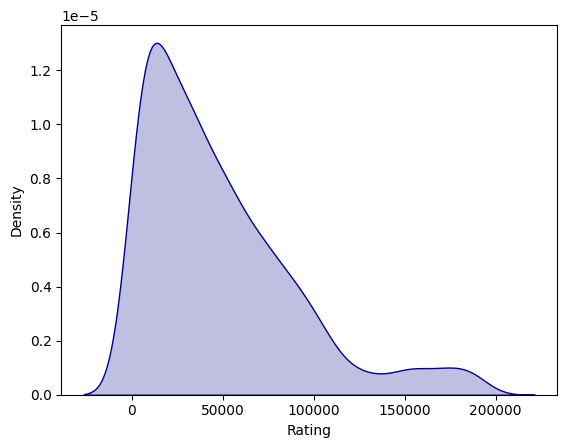

In [ ]:
#Densidad de columna Ranked
sns.kdeplot(anime["Ranked"], shade=True, color='darkblue')
plt.xlabel(col)
plt.show()

In [ ]:
#Intentamos bucle para que nos muestre todas?
num_cols = anime.select_dtypes(include=["int64", "float64"])

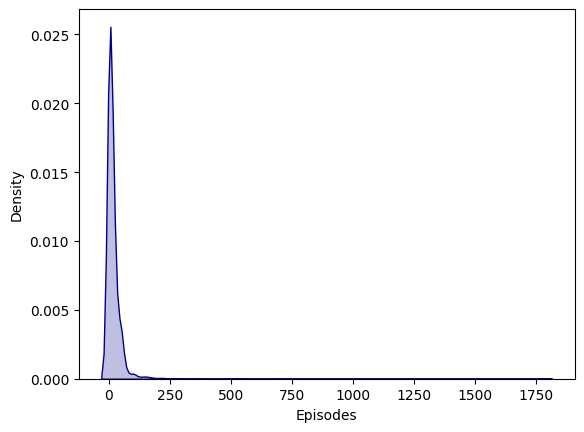

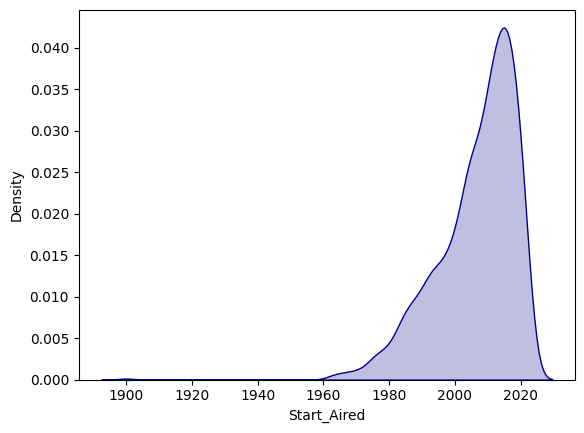

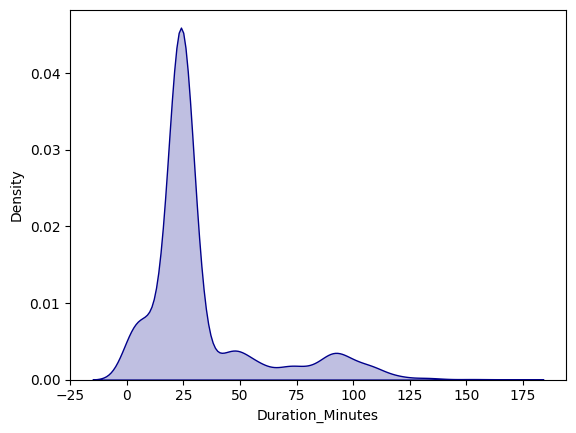

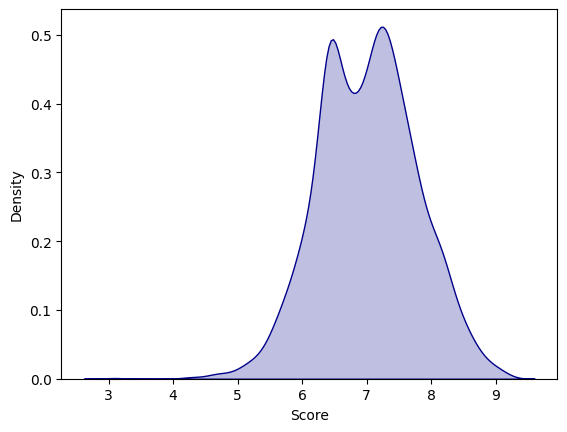

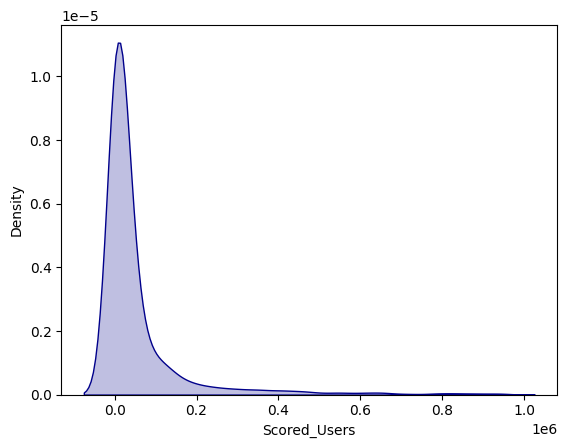

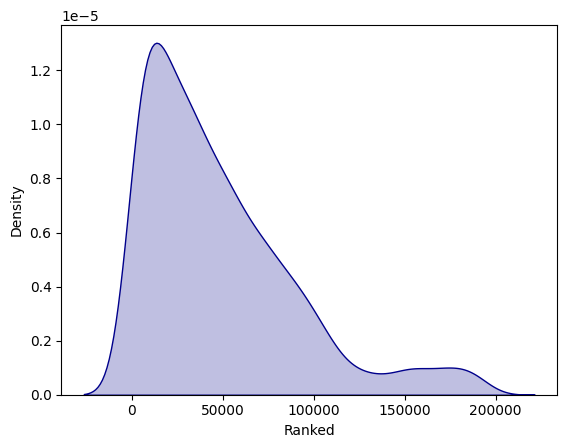

In [ ]:
for col in num_cols:
    sns.kdeplot(anime[col], shade=True, color='darkblue')
    plt.xlabel(col)
    plt.show()


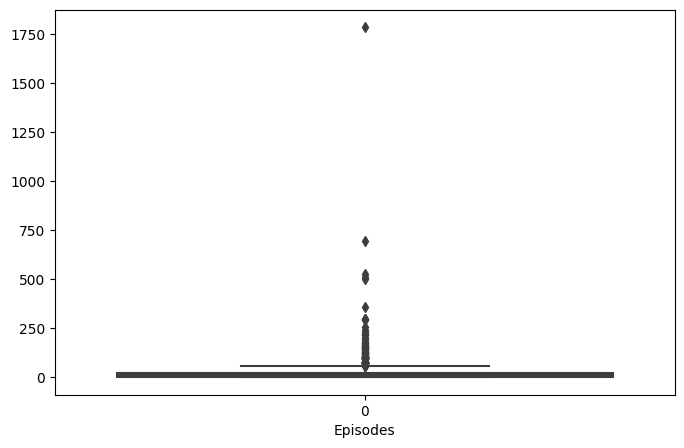

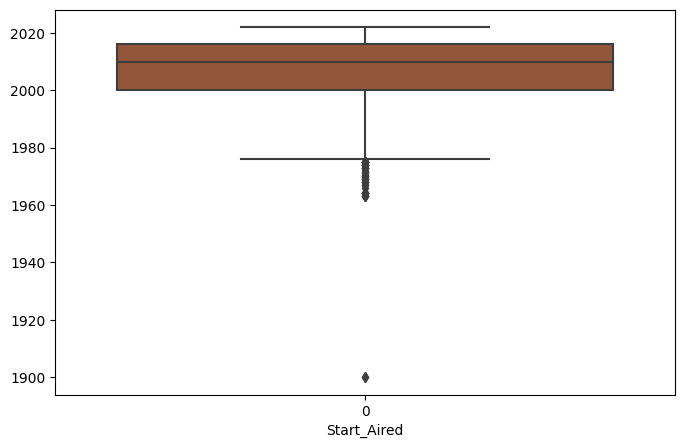

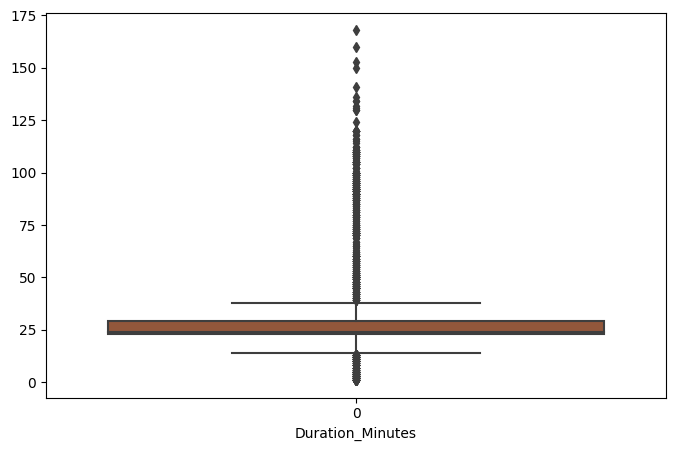

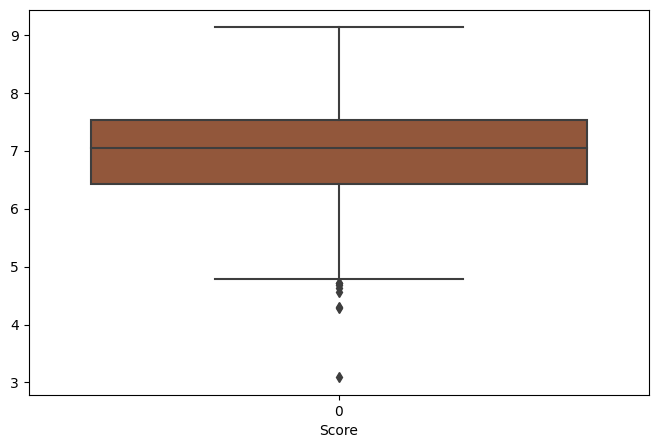

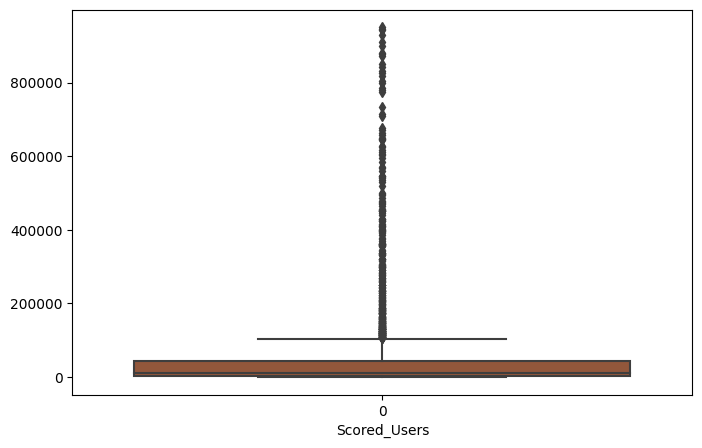

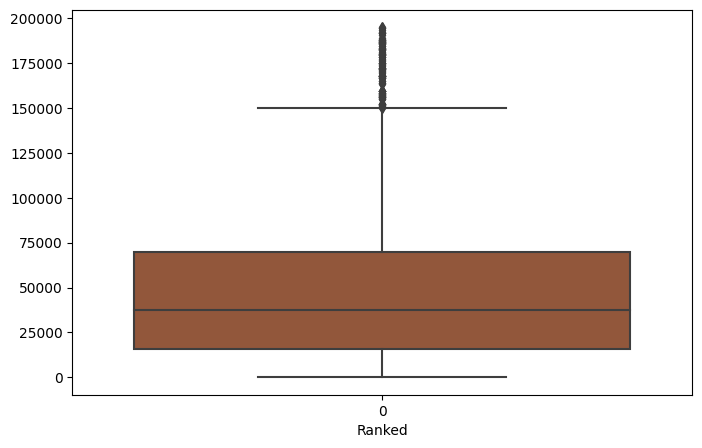

In [ ]:
#Ahora con boxplots. Poner los datos de media/moda/etc  como leyenda dentro del boxplot

for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.boxplot(anime[col], color="sienna");
    plt.xlabel(col)


In [ ]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2548 entries, 0 to 21182
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             2548 non-null   object 
 1   English           2548 non-null   object 
 2   Type              2548 non-null   object 
 3   Episodes          2548 non-null   float64
 4   Status            2548 non-null   object 
 5   Start_Aired       2548 non-null   int64  
 6   Studios           2548 non-null   object 
 7   Source            2548 non-null   object 
 8   Genres            2548 non-null   object 
 9   Themes            2548 non-null   object 
 10  Demographics      2548 non-null   object 
 11  Duration_Minutes  2548 non-null   float64
 12  Rating            2548 non-null   object 
 13  Score             2548 non-null   float64
 14  Scored_Users      2548 non-null   float64
 15  Ranked            2548 non-null   float64
dtypes: float64(5), int64(1), object(10)
memor

Media/moda/mediana/varianza

In [ ]:
num_cols.mean()

Episodes               18.274869
Start_Aired          2006.363815
Duration_Minutes       32.543801
Score                   7.014827
Scored_Users        54262.310672
Ranked              48425.304553
dtype: float64

In [ ]:
#La moda es el valor del conjunto de datos que tiene una mayor frecuencia absoluta,
# es decir, la moda es el valor que más se repite de un conjunto de datos.

#Parece que la columna Ranked es multimodal: cuando se repiten más de dos valores el máximo número de veces.
num_cols.mode()

,Episodes,Start_Aired,Duration_Minutes,Score,Scored_Users,Ranked
0,1.0,2016.0,24.0,6.421724,26507.173809,19652.0
1,NaN,NaN,NaN,NaN,NaN,34422.0
2,NaN,NaN,NaN,NaN,NaN,38772.0
3,NaN,NaN,NaN,NaN,NaN,41652.0
4,NaN,NaN,NaN,NaN,NaN,59732.0
5,NaN,NaN,NaN,NaN,NaN,72862.0


In [ ]:
# la mediana es el valor que ocupa la posición central cuando los datos están ordenados.
num_cols.median()

Episodes               11.000
Start_Aired          2010.000
Duration_Minutes       24.000
Score                   7.041
Scored_Users        11498.000
Ranked              37532.000
dtype: float64

In [ ]:
num_cols.var()

Episodes            2.484081e+03
Start_Aired         1.483116e+02
Duration_Minutes    6.598739e+02
Score               5.774473e-01
Scored_Users        1.450563e+10
Ranked              1.785994e+09
dtype: float64

- ANÁLISIS BIVARIANTE

(Enfrentar las más importantes)

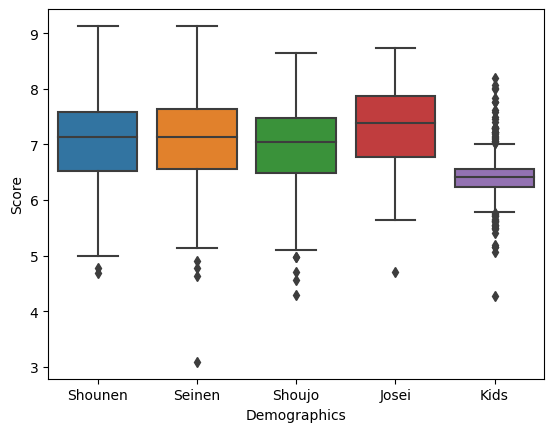

In [ ]:
#Score con demográfica. Con swarmplot queda horrible xD

sns.boxplot(data=anime, x="Demographics", y="Score");


In [ ]:
x= anime[anime.Start_Aired.between(0,2010)]["Start_Aired"]
x.unique()

array([2006, 2009, 2002, 2007, 2004, 2010, 2003, 1989, 2008, 1986, 2005,
       1988, 1999, 2000, 1998, 2001, 1992, 1996, 1995, 1997, 1993, 1994,
       1984, 1979, 1971, 1983, 1970, 1987, 1980, 1991, 1978, 1985, 1977,
       1990, 1972, 1967, 1981, 1982, 1973, 1963, 1975, 1969, 1974, 1968,
       1966, 1976, 1964, 1900], dtype=int64)

In [ ]:
y= anime[anime.Start_Aired.between(0,2010)]["Score"]

<AxesSubplot:xlabel='Start_Aired', ylabel='Score'>

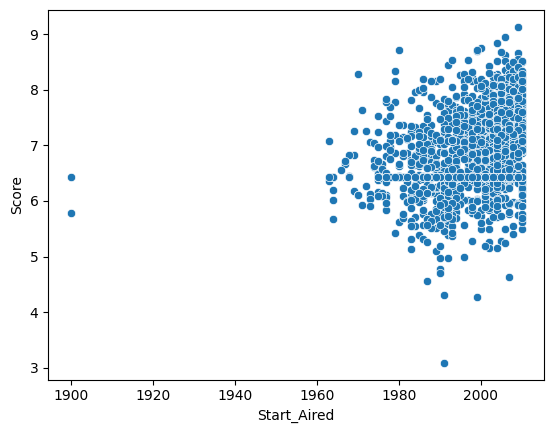

In [ ]:
sns.scatterplot(x=x,y=y)

In [ ]:
def year_to_decade(years):
    decade = (years//10) * 10
    decade = f'{decade}s'
    return decade

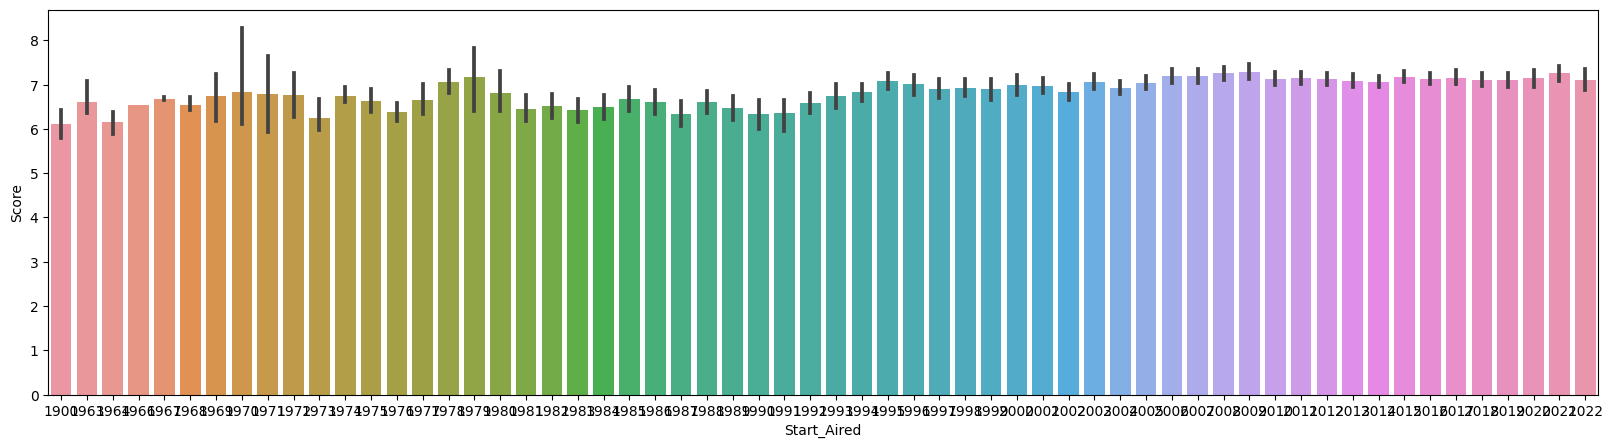

In [ ]:
#Start_Aired con Score. Con Boxplot no me mola. Scatterplot no está mal.

plt.figure(figsize=(20,5))
pd.date_range(1900, periods = 10)
# sns.boxplot(data=anime, x="Start_Aired", y="Score");
sns.barplot(x=anime["Start_Aired"],
                y=anime['Score']);
                # hue = anime['Demographics']


#¿Mejor agrupar los Start_Aired hasta 2010 incluido y después de 2010?

In [ ]:
def year_to_decade(years):
    decade = (years//10) * 10
    decade = f'{decade}s'
    return decade

<AxesSubplot:xlabel='Demographics', ylabel='Ranked'>

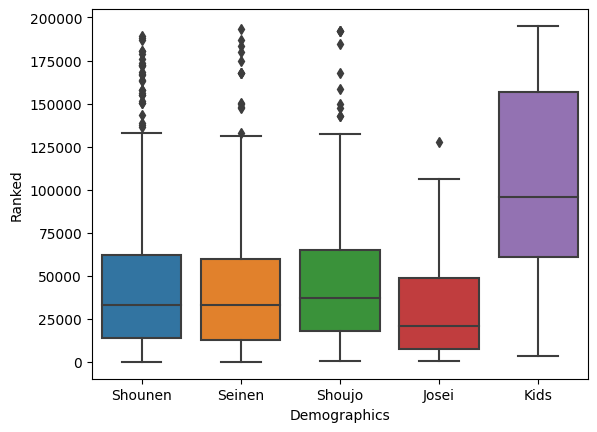

In [ ]:
#Ranked con demográfica. No le veo mucho sentido a esto

sns.boxplot(data=anime, x="Demographics", y="Ranked")
# sns.swarmplot(data=anime, x="Demographics", y="Ranked",
#              color="grey", edgecolor="black");

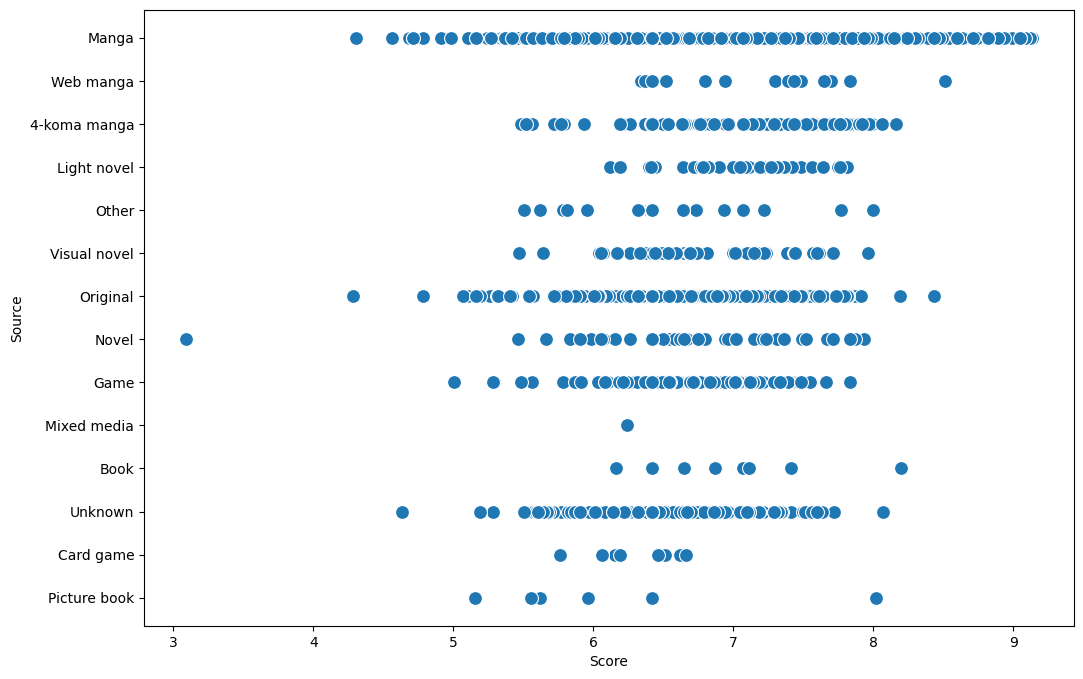

In [ ]:
#Relación de puntuación en base a la fuente del anime
plt.figure(figsize=(12,8))
sns.scatterplot(x=anime["Score"],
                y=anime['Source'],
                # hue = anime['Demographics'],
               s=100);

- ANÁLISIS MULTIVARIANTE

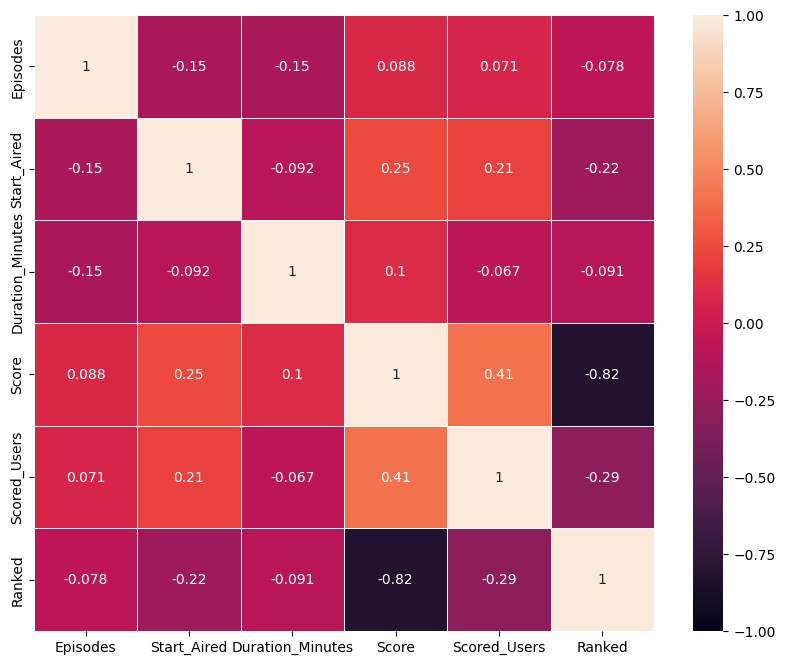

In [ ]:
#heatmap . Solo puede ser con numéricas
num_cols = anime.select_dtypes(include=["int64", "float64"])
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(anime.corr(),
            annot=True,
            linewidths=.5,
            ax=ax,
            vmin=-1,
            vmax=1);

#Resultado lógico: las dos columnas con más correlación "Score" con "Ranked". Obviamente, cuanto
# mayor es la puntuación, más alta es la posición en el ranking. (-0.82)
# con 0.41 ,Las que menos relacionadas están son 

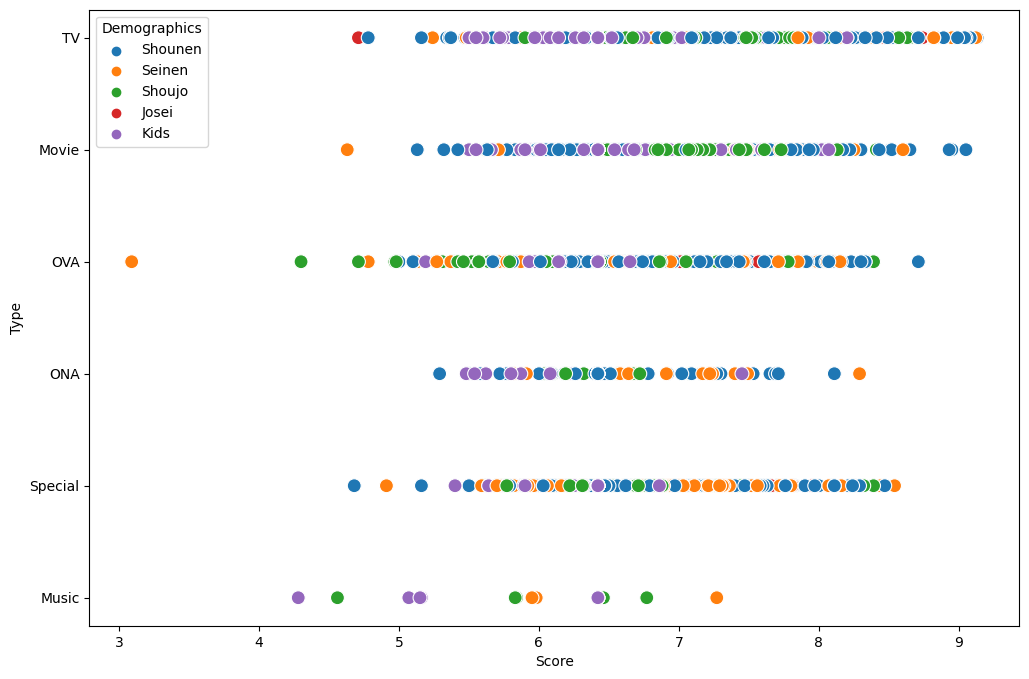

In [ ]:
#Relación de puntuación en base a el tipo de anime y el público objetivo
plt.figure(figsize=(12,8))
sns.scatterplot(x=anime["Score"],
                y=anime['Type'],
                hue = anime['Demographics'],
               s=100);

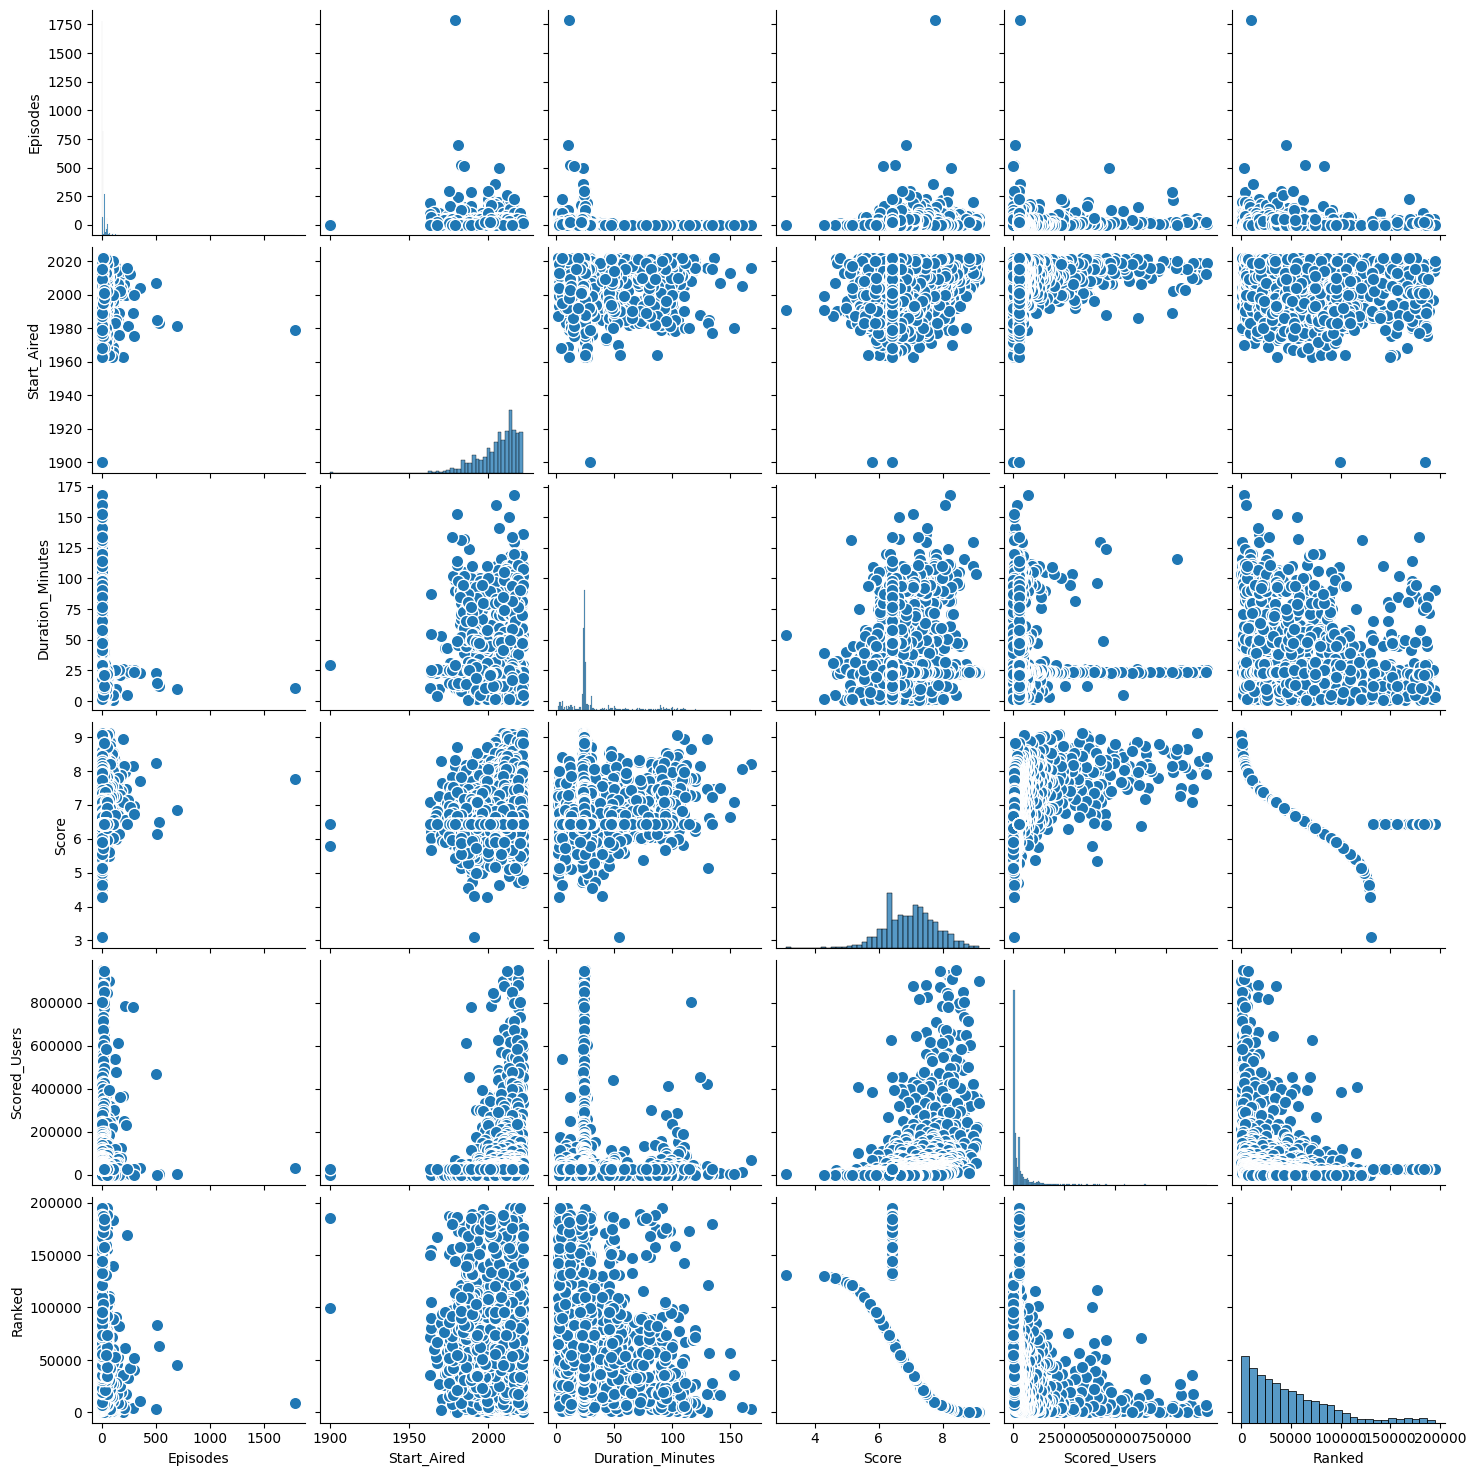

In [ ]:
#pairplot con todas las variables numéricas? A mí no me dice mucho. Aunque la curva de score-ranked es fea

sns.pairplot(anime,
            kind="scatter",
            plot_kws=dict(s=80,
            edgecolor="white",
            linewidth=1));
plt.savefig('gra1.png')

## HIPÓTESIS

### Hipótesis 1:
 
Los 100 animes mejor valorados son mayoritariamente Shounen de acción.

<!-- - Los animes de género comedia tienen más posibilidades de tener una puntuación superior a 4/5
- La puntuación de las películas es inferior a las de las series
- Los animes de aventura tienen más usuarios que puntúan en comparación a comedia, pero la puntuación media es menor
- Los animes basados en manga tienen una puntuación media superior a los animes originales - histograma (pero se puede hacer con estadística)/ boxplot --> -->

In [ ]:
# Ordenar el DataFrame en base a la columna "Ranked"
anime_sorted = anime.sort_values(by=["Ranked"])

# Establecer la columna "Ranked" como índice del DataFrame
anime_sorted.set_index("Ranked", inplace=True)

# Reiniciar los índices del DataFrame empezando desde 1
anime_sorted.reset_index(drop=True, inplace=True)
anime_sorted.index = anime_sorted.index + 1
#Creo una variable con los 100 primeros
top100 = anime_sorted.iloc[:100]
top100.head

,Title,English,Type,Episodes,Status,Start_Aired,Studios,Source,Genres,Themes,Demographics,Duration_Minutes,Rating,Score,Scored_Users
1,Fullmetal Alchemist: Brotherhood,Fullmetal Alchemist Brotherhood,TV,64.0,Finished Airing,2009,Bones,Manga,Action,Military,Shounen,24.0,R - 17+ (violence & profanity),9.131,900398.0
2,Kaguya-sama wa Kokurasetai: Ultra Romantic,Kaguya-sama Love is War - Ultra Romantic,TV,13.0,Finished Airing,2022,A-1 Pictures,Manga,Comedy,Psychological,Seinen,23.0,PG-13 - Teens 13 or older,9.121,335909.0
3,Gintama°,Gintama Season 4,TV,51.0,Finished Airing,2015,Bandai Namco Pictures,Manga,Action,Gag Humor,Shounen,24.0,PG-13 - Teens 13 or older,9.081,222441.0
4,Shingeki no Kyojin Season 3 Part 2,Attack on Titan Season 3 Part 2,TV,10.0,Finished Airing,2019,Wit Studio,Manga,Action,Gore,Shounen,23.0,R - 17+ (violence & profanity),9.071,357688.0
5,Gintama',Gintama Season 2,TV,51.0,Finished Airing,2011,Sunrise,Manga,Action,Gag Humor,Shounen,24.0,PG-13 - Teens 13 or older,9.051,213983.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,Bakuman. 2nd Season,Bakuman Season 2,TV,25.0,Finished Airing,2011,J.C.Staff,Manga,Comedy,Otaku Culture,Shounen,24.0,PG-13 - Teens 13 or older,8.361,201038.0
97,Haikyuu!! To the Top,Haikyu!! To the Top,TV,13.0,Finished Airing,2020,Production I.G,Manga,Sports,School,Shounen,24.0,PG-13 - Teens 13 or older,8.361,496236.0
98,Hellsing Ultimate,Hellsing Ultimate,OVA,10.0,Finished Airing,2006,"Madhouse, Satelight, Graphinica",Manga,Action,Adult Cast,Seinen,49.0,R - 17+ (violence & profanity),8.361,439844.0
99,Kiseijuu: Sei no Kakuritsu,Parasyte The Maxim,TV,24.0,Finished Airing,2014,Madhouse,Manga,Action,Gore,Seinen,23.0,R - 17+ (violence & profanity),8.351,45452.0


<Figure size 2000x2000 with 0 Axes>

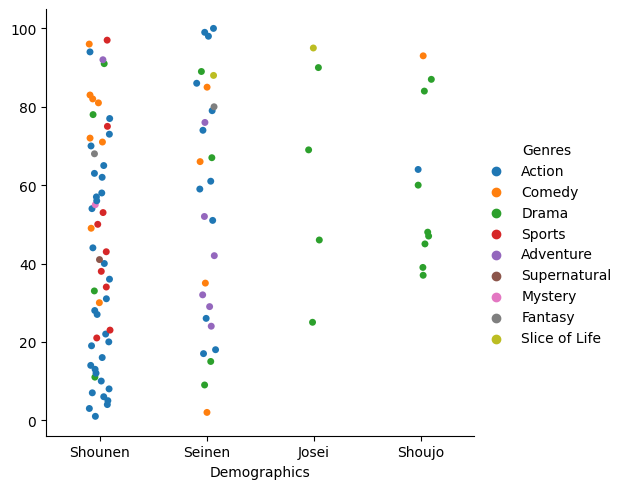

In [ ]:
# Lo representamos con un catplot
plt.figure(figsize=(20,20))
sns.catplot(x="Demographics", y=top100.index, hue="Genres", data=top100);

### Conclusión hipótesis 1

La gráfica muestra que la mayoría de los 100 animes mejor valorados se dirigen a público masculino de 12-18 años (Shounen). De la misma manera, se observa una mayoría de animes de acción en la muestra. 

**Se confirma la hipótesis**

### Hipótesis 2:
 
- La puntuación está relacionada de forma inversa con la duración en minutos (a mayor duración, menor puntuación).

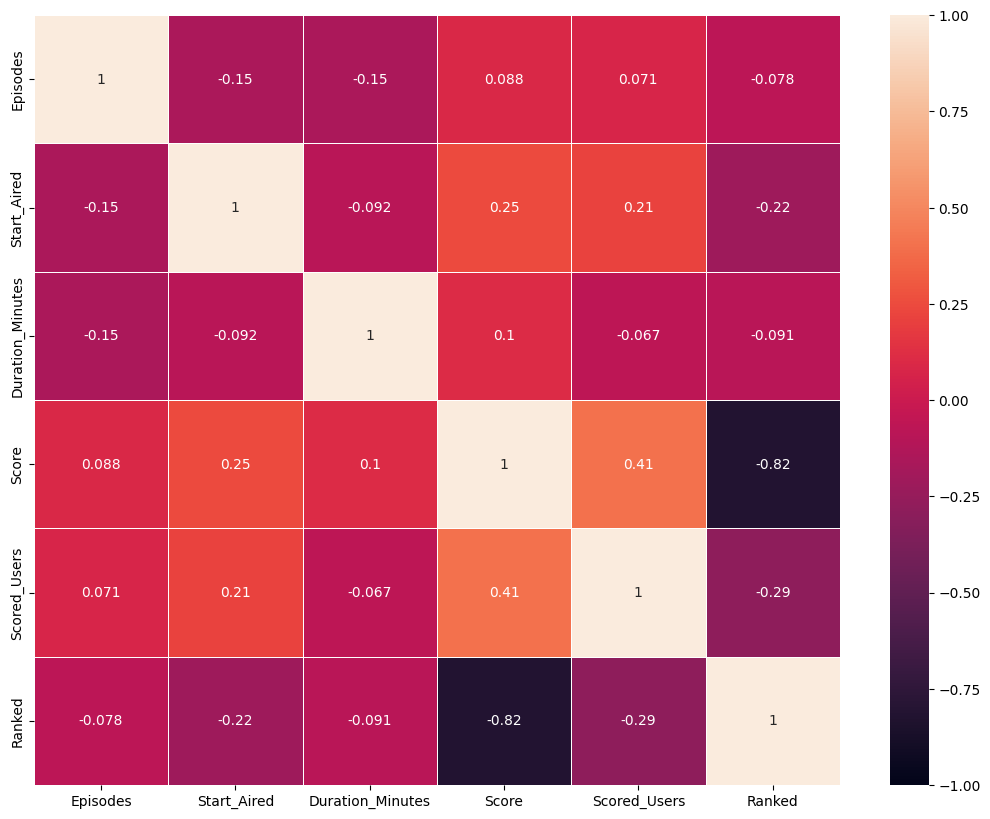

In [ ]:
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(anime.corr(),
            annot=True,
            linewidths=.5,
            ax=ax,
            vmin=-1,
            vmax=1);

Según el heatmap, ambas variables tienen una pequeña correlación positiva. Por lo tanto cuando aumenta una, aumenta levemente la otra.

En principio, **no se confirma la hipótesis**.

Sin embargo, probemos con un test de hipótesis para más fiabilidad.

H0: La puntuación de los animes está inversamente relacionada con su duración.n\
H1: La puntuación de los animes está directamente relacionada con su duración.

Nivel de significancia: 0,05

Comprobemos primero si los datos se ajustan a una distribución normal:

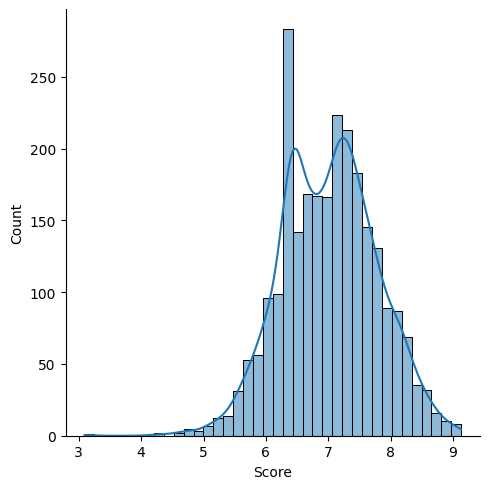

In [ ]:
#Debido al tamaño de la muestra, se decide realizar una prueba de Shapiro-Wilk para ambas variables. Primero con Score

x = anime["Score"]
sns.displot(x, kde=True);

In [ ]:
stats.shapiro(x)

ShapiroResult(statistic=0.713942289352417, pvalue=0.0)

In [ ]:
# Test de normalidad de Shapiro-Wilk
stat, p = stats.shapiro(x)
print('Shapiro-Wilk:')
print(f'Statistic : {stat:.4f}, p-value : {p}')

Shapiro-Wilk:
Statistic : 0.7139, p-value : 0.0


In [ ]:
def hypotesis_check(p_value):
    alpha=0.05
    # Decisión en función del p-valor y el nivel de significación
    if p < alpha:
        print("Rechazar la hipótesis nula: la muestra no parece seguir una distribución normal")
    else:
        print("No se puede rechazar la hipótesis nula: la muestra parece seguir una distribución normal")

hypotesis_check(p)

Rechazar la hipótesis nula: la muestra no parece seguir una distribución normal


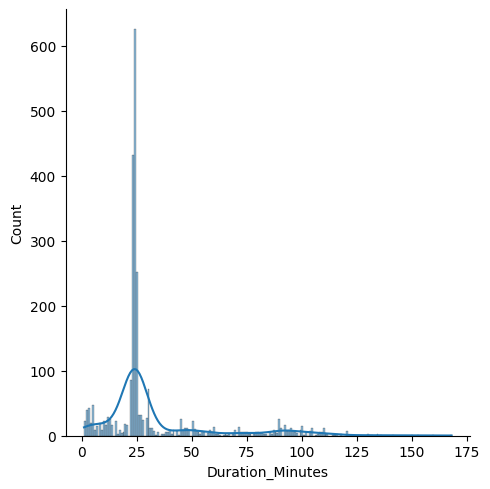

In [ ]:
#Ahora lo mismo pero con "Duration_Minutes". Debido a que la muestra es mayor, se decide hacer un test de D'agostino Pearson
x = anime["Duration_Minutes"]
sns.displot(x, kde=True);

In [ ]:
# Test de normalidad de D'Agostino-Pearson
stat, p = stats.normaltest(x)
print("\nD'Agostino-Pearson:")
print(f'Statistic: {stat:.4f}, p-value: {p:.4f}')


D'Agostino-Pearson:
Statistic: 917.2678, p-value: 0.0000


In [ ]:
alpha=0.05

# Decisión en función del p-valor y el nivel de significación
if p < alpha:
    print("Rechazar la hipótesis nula: la muestra no parece seguir una distribución normal")
else:
    print("No se puede rechazar la hipótesis nula: la muestra parece seguir una distribución normal")

Rechazar la hipótesis nula: la muestra no parece seguir una distribución normal


Se demuestra que ninguno de los datos siguen una distribución normal, por lo que pondremos a prueba nuestra hipótesis con un test no paramétrico.

 Necesitamos comparar la distribución de dos o más muestras independientes de datos ordinales o continuos no paramétricos, por lo que realizaremos la prueba de Kruskal Wallis.

In [ ]:
from scipy.stats import mannwhitneyu

In [ ]:
duracion = anime[anime["Duration_Minutes"]!=0]["Duration_Minutes"]
puntuacion = anime[anime["Score"]!=0]["Score"]

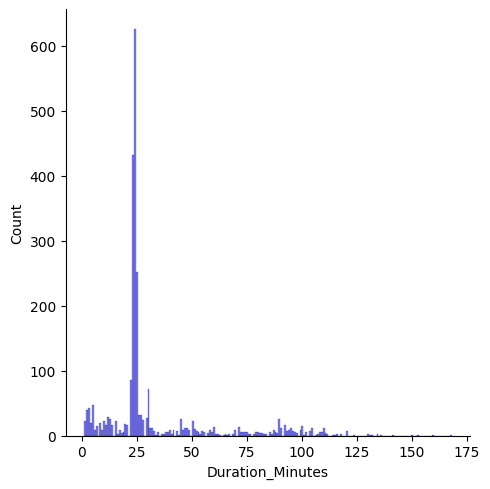

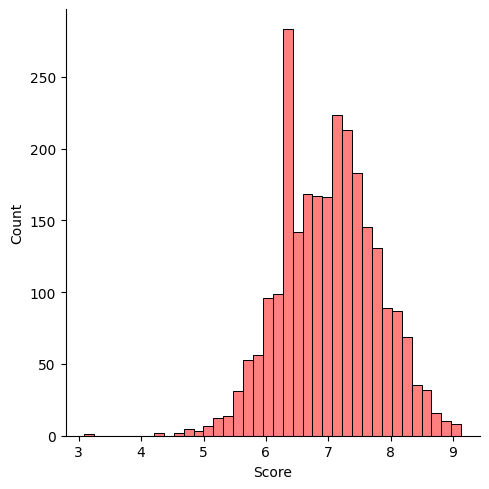

In [ ]:
sns.displot(duracion, color='blue', alpha=0.5)
sns.displot(puntuacion, color='red', alpha=0.5)

In [ ]:
U, p_valor = mannwhitneyu(duracion, puntuacion)

print("Estadístico U: ", U)
print("P-valor: ", p_valor)

Estadístico U:  6008323.0
P-valor:  0.0


In [ ]:
# Seleccion del nivel de significancia
alpha = 0.05

# Decisión en función del p-valor y el nivel de significación
if p_valor < alpha:
    print("Rechazar la hipótesis nula (p-value: {:.4f})".format(p_valor))
else:
    print("No se puede rechazar la hipótesis nula (p-value: {:.4f})".format(p_valor))


Rechazar la hipótesis nula (p-value: 0.0000)


**No se confirma la hipótesis número 2**. La duración de los animes no está relacionada de forma inversa con su puntuación.

### Hipótesis 3:
 
-Los animes cuya emisión empezó antes de los 2000 tienen peor puntuación que los animes que empezaron a emitirse después del 2000.

Desarrollo de la idea: https://www.menzig.es/a/historia-anime-espana-origenes/

En España se ha emitido anime desde la década de los 70 (Heidi, Mazinger Z). Sin embargo, no fue hasta la década de los 90 cuando los animes llegaron a la televisión para quedarse ( Dragon Ball, OLiver y Benji). Partiendo de esta base, ¿los animes que comenzaron después del 2000 están mejor valorados por su mejora artística y su mayor cercanía en el tiempo o, por el contrario, los animes anteriores al 2000 están mejor valorados debido a la nostalgia que despiertan?